Дипломный проект


Тема: "Модель прогнозирования стоимости жилья для агентства недвижимости по брифу учебного кейса"


Задача — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

Описание данных:
*
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

1 Этап. Предобработка данных

импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import re
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.exc import GeocoderServiceError

посмотрим на наши данные

In [2]:
data = pd.read_csv('data.csv')
display(data.head(5))


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
print('размерность таблицы: {}'.format(data.shape))

размерность таблицы: (377185, 18)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Удалим дубликаты

In [5]:
print('Первоначальное количество строк:', data.shape[0])
data.drop_duplicates(ignore_index=True, inplace=True)
print('количество строк после удаления:', data.shape[0])

Первоначальное количество строк: 377185


количество строк после удаления: 377135


несложно посчитать, всего было удалено 50 дубликатов

посмотрим на пропуски в нашем датасете

In [6]:
display(data.isnull().sum())

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274024
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150674
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

Как мы видим из 18 столбцов нашего датасета, лишь 4 без пропусков:'homeFacts','schools','zipcode','state'

Посмотрим % соотношение пропусков в наших данных

In [7]:
isnull_data = data.isnull().mean().mul(100).sort_values(ascending=False)
for column_name, isnull_data in isnull_data.items():
    if isnull_data > 0:
        print(f'{column_name}:{isnull_data:.4f}%')
       
    

private pool:98.8914%
mls-id:93.3865%
PrivatePool:89.3115%
fireplace:72.6594%
stories:39.9523%
baths:28.1883%
beds:24.1966%
MlsId:17.7308%
sqft:10.7521%
status:10.5843%
propertyType:9.2097%
target:0.6576%
city:0.0090%
street:0.0005%


Итак мы увидели,что в столбцах нашего датасета:

количество пропусков меньше 1%: 'target', 'city', 'street';

1-20% пропусков: 'MlsId', 'sqft', 'status', 'propertyType';

20-40% пропусков: 'stories', 'baths', 'beds';

более 40% пропусков: 'private', 'mls', 'PrivatePool', 'fireplace'.

Удаление неинформатифных признаков

mls-id, MlsId -  существуют для идентификации объекта в общих базах риэлторов , а значит их можно удалить

In [8]:
# удаление неинформативных признаков
data.drop(columns=['mls-id', 'MlsId'], inplace=True)

Проверим

In [9]:
data.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'PrivatePool', 'target'],
      dtype='object')

колонки 'private pool' и 'PrivatePool' у нас имеют один признак— кол-во пропусков в данных пордка 90%
Посмотрим ,что содержится в private pool и PrivatePool


In [10]:
print(data['private pool'].unique())
print(data['PrivatePool'].unique())

[nan 'Yes']
[nan 'yes' 'Yes']


Поскольку 'private pool' и 'PrivatePool' содержат дублирующую информацию , объеденим их.так же отметим , что поскольку у нас всего 3 значения то вероятнее всего пропуск свидетельствует об отсутствии бассейна, закодируем их

In [11]:
# содержимое столбцов до объединения и обработки
display(data['private pool'].value_counts())
print('\n')
display(data['PrivatePool'].value_counts())

private pool
Yes    4181
Name: count, dtype: int64

PrivatePool
yes    28792
Yes    11518
Name: count, dtype: int64

In [12]:
#Заменяем 'yes' и 'Yes' на 1,остальные признаки на 0
data['private pool'] = data['private pool'].apply(lambda x: 1 if x=='Yes' else 0)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)
     
#Объединим признаки 'privat pool' и 'PrivatPool' в общий признак 'pool'.

data['pool'] = data['private pool'] | data['PrivatePool']
#Удаляем лишние столбцы
data.drop(['private pool'], axis=1, inplace=True)
data.drop(['PrivatePool'], axis=1, inplace=True)
     

data['pool'].value_counts()

pool
0    332644
1     44491
Name: count, dtype: int64

удалим дубликаты

In [13]:
print(' количество строк до удаления:', data.shape[0])
data.drop_duplicates(ignore_index=True, inplace=True)
print('Итоговое количество строк:', data.shape[0])

 количество строк до удаления: 377135
Итоговое количество строк: 377044


Признак 'zipcode'

Признак 'zipcode' является почтовым индексом объекта недвижимости и не оказывает влияния на формирование цены, поэтому его можно удалить.

In [14]:
data.drop(['zipcode'],axis=1, inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377044 entries, 0 to 377043
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337128 non-null  object
 1   propertyType  342319 non-null  object
 2   street        377042 non-null  object
 3   baths         270782 non-null  object
 4   homeFacts     377044 non-null  object
 5   fireplace     103110 non-null  object
 6   city          377012 non-null  object
 7   schools       377044 non-null  object
 8   sqft          336508 non-null  object
 9   beds          285839 non-null  object
 10  state         377044 non-null  object
 11  stories       226460 non-null  object
 12  target        374564 non-null  object
 13  pool          377044 non-null  int64 
dtypes: int64(1), object(13)
memory usage: 40.3+ MB


Посмотри на признак status,% пропусков 10.5843%

In [16]:
#посмотрим на количество уникальных значений
data.status.value_counts()

status
for sale                156052
Active                  105125
For sale                 43464
foreclosure               6425
New construction          5474
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: count, Length: 159, dtype: int64

уникальных значений очень много.Уменьшаем количество значений данного признака - разделим статусы на категории, пропуски заменим на Оther

In [17]:
categories = {
    "For Sale": ["for sale", "For sale", "New construction", "New"],
    "Active": [
        "Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        "Temporary Active", "Re Activated", "Reactivated"
    ],
    "Pending": [
        "P", "Pending", "pending", "P Pending Sale", "Pending Ab", "Pending Continue To Show",
        "Pending Inspection", "Pending Offer Approval", "Pending In", "Pending W/Insp Finance", "Pending Fe",
        "Pending W/Backup Wanted", "Pending Backups Wanted", "Pending With Contingencies", "Lease/Purchase Pending",
        "Pending Bring Backup", "Pending - Taking Backups", "Pending - Continue to Show",
        "Pending Taking Backups", "Offer Pending Signature", "Pending (Do Not Show)", "Pending W/ Cont.",
        "Pending W/Escape Clause", "Pending - Backup Offer Requested", "Pending Sale"
    ],
    "Contingent": [
        "Contingent", "Contingent Finance And Inspection", "Contingent Show",
        "Contingent Take Backup", "Contingent - Sale of Home", "Contingent Finance and Inspection",
        "C Continue Show", "Contingent   Show", "Contingent   Release", "Contingent   No Show",
        "CT Insp - Inspection Contingency", "Contingent   Foreclosure", "Conting Accpt Backups",
        "Contingent - Financing", "Contingency 48 Hr (+/ )", "Contingency Contract", "Contingent Escape"
    ],
    "Foreclosure": [
        "Pre-foreclosure", "Pre-foreclosure / auction", " / auction", "Foreclosed", "foreclosure", "Foreclosure"
    ],
    "Under Contract": [
        "Under Contract", "Under Contract   Showing", "Under Contract Backups", "Under Contract Show",
        "Under Contract - Show", "Under Contract - No Show", "Under contract", "U Under Contract",
        "Due Diligence Period", "Contract Contingent On Buyer Sale", "Contract P", "Ct", "Uc Continue To Show",
        "Under Contract Taking Back Up Offers", "Under Contract W/ Bckp", "Contract"
    ],
    "For Rent": ["for rent", "Apartment for rent", "Condo for rent"],
    "Auction": ["Auction"],
    "Recently Sold": ["recently sold"],
    "Price Change": ["Price Change"],
    "Back on Market": ["Back on Market", "Back On Market"],
    "Closed": ["Closed"],
    "Listing Extended": ["Listing Extended"],
    "Coming Soon": [
        "Coming soon: Nov 21.", "Coming soon: Dec 4.", "Coming soon: Nov 23.", "Coming soon: Nov 29.",
        "Coming soon: Dec 2.", "Coming soon: Dec 10.", "Coming soon: Dec 24.", "Coming soon: Nov 14.",
        "Coming soon: Nov 22.", "Coming soon: Oct 21.", "Coming soon: Dec 14.", "Coming soon: Oct 24.",
        "Coming soon: Dec 18.", "Coming soon: Dec 16.", "Coming soon: Dec 3.", "Coming soon: Dec 25.",
        "Coming soon: Nov 11.", "Coming soon: Nov 28.", "Coming soon: Nov 17.", "Coming soon: Dec 6.",
        "Coming soon: Nov 27.", "Coming soon: Nov 26.", "Coming soon: Dec 7.", "Coming soon: Dec 27.",
        "Coming soon: Dec 11.", "Coming soon: Dec 5.", "Coming soon: Nov 13.", "Coming soon: Nov 19.",
        "Coming soon: Nov 8.", "Coming soon: Oct 29.", "Coming soon: Dec 15.", "Coming soon: Oct 30.",
        "Coming soon: Dec 9.", "Coming soon: Dec 20.", "Coming soon: Dec 13.", "Coming soon: Dec 23.",
        "Coming soon: Nov 30.", "Coming soon: Dec 1.", "Coming soon: Nov 5.", "Coming soon: Nov 12.",
        "Coming soon: Nov 25.", "Coming soon: Nov 9."
    ],
}

def categorize_status(status_value):
    for category, values in categories.items():
        if status_value in values:
            return category
    return "Other"

# заменим значения на категории
data['status'] = data['status'].apply(categorize_status)

Посмотри сколько у нас теперь уникальных значений и удалось ли нам убрать пропуски

In [18]:
missing_values_count = data.status.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.status.nunique()}\n"
      f"Уникальные значения: {list(data.status.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 15
Уникальные значения: ['Active', 'For Sale', 'Other', 'Pending', 'Foreclosure', 'Under Contract', 'For Rent', 'Auction', 'Contingent', 'Price Change']


In [19]:
print(' количество строк до удаления:', data.shape[0])
data.drop_duplicates(ignore_index=True, inplace=True)
print('Итоговое количество строк:', data.shape[0])

 количество строк до удаления: 377044


Итоговое количество строк: 377044


Посмотрим признак 'street',% пропущенных значений 0.0005 , количество пропущенных значений всего 2, эти строки явно ни на что не влияют, можно их удалить

In [20]:
# удаляем строки, где есть пропуски в признаке 'street'
data = data.dropna(subset=['street'])

посмотрим на признак 'propertyType',% пропусков 9,2097

In [21]:
data.propertyType.value_counts()

propertyType
single-family home                                             92199
Single Family                                                  62867
Single Family Home                                             31691
condo                                                          25964
lot/land                                                       20518
                                                               ...  
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
1 Story, Contemporary, Traditional, Mediterranean                  1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: count, Length: 1280, dtype: int64

уникальных значений 1280.
Попробуем уменьшить кол-во значений

In [22]:
# приводим тип к строке и к нижнему регистру
data.propertyType = data.propertyType.str.lower()
# приводим разное написание типа single-family к одному виду, заменяем yes и unknown на Other
data.propertyType = data.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') \
.str.replace('yes','Other') \
.str.replace('unknown','Other')
# Создадим признак Type и запишем в него объединенные по одному слову данные 
data['Type'] = data['propertyType'].str.split(',').str[0]

посмотрим сколько у нас теперь уникальных значений 

In [23]:
data.Type.value_counts()

Type
single family                   186757
condo                            42525
lot/land                         20518
townhouse                        18529
land                             10899
                                 ...  
2.5 story                            1
mobile home                          1
double-wide mobile with land         1
2 story condo                        1
cottage/camp                         1
Name: count, Length: 256, dtype: int64

удалось сократить до 256 уникальных значений, но это все равно много.
Попробуем отыскать синонимы и заменить их

In [24]:
# находим синонимы в данных
synonyms_mapping = {
    'single_family_home': [
        'single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
    'other': [
        'Other', 'english', 'urban contemporary', 'other style', 'florida', 'farms/ranches', 'carriage house', 'country english', 'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor', 'new build 2019', 'split foyer', 'cottage', 'cottage/camp', 'garden home', 'farm/ranch', 'farm/ranch house', 'farm house', 'hi ranch', 'attached duplex', 'farmhouse', 'houseboat', 'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara/tuscan', 'old style', 'modular/prefab', 'post and beam', 'manuf/mobile', 'multiple occupancy', 'attached', 'hawaiian plantation', 'forest garden home', '1 1/2 story with basement', 'split-entry', 'texas hill country', 'lake house', '1 story with basement', 'hi-rise', 'coastal beach home', 'historical', 'key west/coastal', 'loft/balcony', 'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander', 'residential (<1 acre)', 'ranch','residential (1+ acre)', 'split', 'split level', 'split (4 level)', 'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian/federal', 'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'mountain contemporary', 'key west', 'high ranch', 'end unit']
}


def replace_synonyms(value):
    for key, synonym_values in synonyms_mapping.items():
        if value in synonym_values:
            return key
    return "other"

# Замена синонимов
data['Type'] = data['Type'].apply(replace_synonyms)

посмотрим сколько теперь у нас уникальных значений и удалось ли избавиться от пропусков

In [25]:
missing_values_count = data.Type.isna().sum()
total_count = len(data)
missing_values_percent = (missing_values_count / total_count) * 100
print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percent:.2f}%\n"
      f"Количество уникальных значений: {data.Type.nunique()}\n"
      f"Уникальные значения: {list(data.Type.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 12
Уникальные значения: ['single_family_home', 'land', 'townhouse', 'other', 'condo', 'multi_family_home', 'mobile_home', 'apartment', 'modern', 'miscellaneous']


Отлично, мы сократили количество значений до 12 и избавились от пропусков

In [26]:
# удаляем propertyType
data.drop('propertyType', axis=1, inplace=True)

Посмотрим на признак storie


Количество пропусков в признаке этажности дома составляет около 40%.
Этот признак не является признаком-индикатором, как столбец с данными о каминах: если в столбце пропущено значение, 
оно несет информацию об отсутствии камина в доме.
Но в каждом доме есть этажи, поэтому отсутствие информации не говорит об отсутствии этажа.
При этом дальнейшая обработка этого признака скорее всего выявит скрытые пропуски, что увеличит долю пропусков.
Поэтому этот столбец неинформативен, удалим его.

In [27]:
data['stories'].unique()

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', 'Lot', '3 Story', 'Three Or More',
       '1.5', '1 Level', 'Two Story or More', 'Site Built, Tri-Level',
       '54.0', '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21',
       '8', '12.0', 'Split Level w/ Sub', '11.0', '18.0', '1.5 Stories',
       '7', '11', 'Townhouse', '12', '21.0', '16', '1.5 Story/Basement',
       '28.0', 'Traditional', '2.5 Story', '17', '2.0000', '63.0',
       'Acreage', 'Ground Level, One', '6', 'Split Foyer', '2 Stories',
       '27.0', '19.0', '2.50', '1.30', '2 Story/Basement', 'Split Level',
       '1.5 Story', '1.5 Level', '2 Or More Stories',
  

In [28]:
data.drop(columns=['stories'], inplace=True)

In [29]:
# делаем копию базы данных
data1=data.copy()

Посмотрим на признак baths,% пропусков 28.1883%
Посмотим на кол-во уникальных значений

In [30]:
data1.baths.value_counts()

baths
2 Baths       52458
3 Baths       35503
2             20439
2.0           16574
4 Baths       14763
              ...  
4.75 Baths        1
5.25 Baths        1
41.0              1
1.8 Baths         1
44.0              1
Name: count, Length: 229, dtype: int64

Количество значений 229, это очеь много.попробуем сократить

In [31]:
# Удаляем буквы, пробелы и двоеточия
data1.baths = data1.baths.str.replace('[a-zA-Z:]','', regex=True)
# Удаляем все пробелы
data1.baths = data1.baths.str.replace(' ','', regex=True)

посмотрим,что получилось

In [32]:
data1.baths.unique()

array(['3.5', '3', '2', '8', nan, '1,750', '4', '5', '1,000', '7', '2.0',
       '3.0', '1', '4.0', '2.1', '2.5', '4.5', '6', '2,500', '5.5', '1.0',
       '1.5', '~', '4,000', '2,000', '3,000', '8.0', '0', '5.0', '1,500',
       '7.0', '1,250', '9', '2,250', '6.0', '12', '3,500', '2,750', '750',
       '5.5+', '10', '19', '10.0', '2.5+', '7.5+', '0/0', '..', '4.5+',
       '18', '--', '3.5+', '1.5+', '11', '5,000', '1.75', '12.0', '1.1',
       '6.5', '16', '13', '14', '9.0', '8.5+', '17', '241', '16.0',
       '10.5+', '6.5+', '7,500+', '7.5', '11.0', '20', '40', '1-0/1-0/1',
       '14.0', '2.75', '24', '22.0', '0.00', '2.25', '3.1', '3.25', '—',
       '22', '32', '18.0', '0.0', '27', '26', '20.0', '9.5', '8.5', '15',
       '35', '3.75', '29', '116/116/116', '21', '5.2', '14.5+', '76',
       '13.0', '', '3-1/2-2', '15.0', '23', '3.3', '43', '1.25', '34',
       '2.2', '1/1/1/1', '55.0', '25', '12.5+', '44', '0.5', '4.25',
       '4.75', '0.75', '4.1', '5.25', '41.0', '1.8', '10.5

148 значений, многовато,видим,что есть некорректные значения.поработаем с ними

In [33]:
# исправляем некорректные значения
data1['baths'] = data1['baths'].str.replace('[a-zA-Z+:]','', regex=True)
data1['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)
data1['baths'].replace(['1-2','1/1-0/1-0/1-0', '1/1/1/1','1-0/1-0/1', ], 1, inplace=True)
data1['baths'].replace(['2-1/2-1/1-1/1-1','3-1/2-2',], 2, inplace=True)
data1['baths'].replace(['116/116/116'], 116, inplace=True)
data1['baths'].replace(['7,500'], 7.5, inplace=True)
data1['baths'].replace(['5,000'], 5, inplace=True)
data1['baths'].replace(['3,500'], 3.5, inplace=True)
data1['baths'].replace(['2,750'], 2.75, inplace=True)
data1['baths'].replace(['2,250'], 2.25, inplace=True)
data1['baths'].replace(['1,250'], 1.25, inplace=True)
data1['baths'].replace(['1,500'], 1.5, inplace=True)
data1['baths'].replace(['4,000'], 4, inplace=True)
data1['baths'].replace(['2,000'], 2, inplace=True)
data1['baths'].replace(['3,000'], 3, inplace=True)
data1['baths'].replace(['2,500'], 2.5, inplace=True)
data1['baths'].replace(['1,000'], 1, inplace=True)
data1['baths'].replace(['1,750'], 1.75, inplace=True)
data1['baths'] = data1['baths'].fillna(0)

In [34]:
# переводим в числовой признак и округляем до целого числа
data1['baths'] = data1['baths'].astype(float).round()

In [35]:
# Отбираем строки по заданным условиям
select_rows = data1[(data1['baths'] == 0) & ((data1['Type'] == 'other') | (data1['Type'] == 'land') | (data1['Type'] == 'ranch'))]

# Выводим полученные строки
display(select_rows.head(3))
# Находим процент выбранных строк от общего числа строк в исходном датафрейме
percent_select = len(select_rows) / len(data1) * 100
# Выводим полученные строки и процент выбранных строк
print(f"Процент выбранных строк от общего числа строк: {percent_select:.2f}%")

,status,street,baths,homeFacts,fireplace,city,schools,sqft,beds,state,target,pool,Type
4,For Sale,1524 Kiscoe St,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,NaN,FL,"$5,000",0,land
6,Active,552 Casanova Ct,0.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",NaN,FL,"181,500",0,other
7,Active,6094 Mingle Dr,0.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,NaN,TN,"68,000",0,other


Процент выбранных строк от общего числа строк: 19.36%


In [36]:
# Отбираем строки по заданным условиям
select_rows = data1[(data1['baths'] == 0) & ~(data1['Type'].isin(['other', 'land', 'ranch']))]
display(select_rows.head(3))
# Находим уникальные значения признака status в выбранных строках
unique_statuses = select_rows['Type'].unique()
# Выводим полученные строки и процент выбранных строк
print(f"Уникальные значения признака Type в выбранных строках: {unique_statuses}")
percent_select = len(select_rows) / len(data1) * 100
print(f"Процент выбранных строк от общего числа строк: {percent_select:.2f}%")

,status,street,baths,homeFacts,fireplace,city,schools,sqft,beds,state,target,pool,Type
5,For Sale,1624 S Newkirk St,0.0,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,2 Beds,PA,"$209,000",0,townhouse
15,For Sale,930 52nd St,0.0,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,NaN,NY,"1,650,000",0,single_family_home
17,Active,24 W 126th St,0.0,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",NaN,NY,"2,650,000",0,townhouse


Уникальные значения признака Type в выбранных строках: ['townhouse' 'single_family_home' 'condo' 'apartment' 'modern'
 'miscellaneous' 'multi_family_home' 'mobile_home' 'historical']
Процент выбранных строк от общего числа строк: 10.25%


In [37]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1.baths.isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data1.baths.nunique()}\n"
      f"Уникальные значения: {list(data1.baths.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 49
Уникальные значения: [4.0, 3.0, 2.0, 8.0, 0.0, 5.0, 1.0, 7.0, 6.0, 9.0]


Прекрасно,кличество значений удалось сократить до 49 и убрать пропущенные значения

Извлечение информации из homeFacts и schools

Признаки homeFacts и schools представляют собой словари JSON и содержат несколько типов сведений о характеристиках объекта недвижимости и о близлежайших школах.

Проведем десериализацию данных.

In [38]:
new_home_facts_cols = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for index, col in enumerate(new_home_facts_cols):
    data1[col] = data1['homeFacts'].apply(lambda x: eval(x).get('atAGlanceFacts')[index].get('factValue'))
    
new_schools_cols = ['name', 'data', 'rating']
for i in new_schools_cols:
    data1[i] = data1['schools'].apply(lambda x: eval(x)[0].get(i))
    
new_schools_cols = ['Distance', 'Grades']
for i in new_schools_cols:
    data1[i] = data1['data'].apply(lambda x: x.get(i))
    
display(data1[['homeFacts', 'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft',
            'schools', 'name', 'rating', 
            'data', 'Distance', 'Grades']].head(1))
data1.drop(columns=['data', 'schools', 'homeFacts'], inplace=True)

Обрабатываем созданные признаки для homeFacts

Поасмотрим на признак Признак 'Year built'

In [ ]:
#Выводим уникальные значения
data1['Year built'].sort_values().unique()

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1780', '1788', '1790', '1794', '1795', '1796',
       '1799', '1800', '1802', '1803', '1804', '1805', '1807', '1808',
       '1809', '1810', '1811', '1812', '1815', '1816', '1817', '1818',
       '1820', '1822', '1823', '1824', '1825', '1828', '1829', '1830',
       '1831', '1832', '1834', '1835', '1836', '1840', '1842', '1843',
       '1844', '1845', '1846', '1847', '1848', '1850', '1851', '1852',
       '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860',
       '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868',
       '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876',
       '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884',
       '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892',
       '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900',
       '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908',
     

In [ ]:
#удаляем лишние кавычки
data1['Year built'] = data1['Year built'].str.replace("'",'', regex=True)
# Заменяем ковычки на 'no date'
data1['Year built'] = data1['Year built'].str.replace('^\s*$','no date', regex=True)
# Заменяем некорректные значения на 'no date'
mask= data1['Year built'].isin(['1','1208','559990649990','2025','No Data',None])
data1.loc[mask,'Year built'] = 'no date'
# Исправляем опечатки
data1.loc[data1['Year built']=='1019','Year built'] = '1919'
data1.loc[data1['Year built']=='1057','Year built'] = '1957'
data1.loc[data1['Year built']=='1060','Year built'] = '1960'
# Выводим результат обработки
data1['Year built'].sort_values().unique()[:20]

array(['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790',
       '1794', '1795', '1796', '1799', '1800', '1802', '1803', '1804',
       '1805', '1807', '1808', '1809'], dtype=object)

In [ ]:
# Отбираем строки по заданным условиям
selected_rows = data1[(data1['Year built'] == 'no date') & ((data1['Type'] == 'other') | (data1['Type'] == 'land') | (data1['Type'] == 'ranch'))]

# Выводим полученные строки
display(selected_rows.head(3))
# Находим процент выбранных строк от общего числа строк в исходном датафрейме
percent_selected = len(selected_rows) / len(data1) * 100
# Выводим полученные строки и процент выбранных строк
print(f"Выбранных строк: {len(selected_rows)}")
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.4f}%")

,status,street,baths,fireplace,city,sqft,beds,state,target,pool,...,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,name,rating,Distance,Grades
4,For Sale,1524 Kiscoe St,0.0,NaN,Palm Bay,NaN,NaN,FL,"$5,000",0,...,,,,,"10,019 sqft",None,"[Southwest Middle School, Bayside High School,...","[4/10, 5/10, 5/10]","[5.96mi, 3.25mi, 3.03mi]","[7-8, 9-12, PK-6]"
26,Active,5755 SW 123 Ave,1.0,NaN,Miami,NaN,Baths,FL,"799,000",0,...,,,,,—,None,"[Royal Green Elementary School, Air Base Eleme...","[9, 10, NR, 6, 3]","[1.0 mi, 13.7 mi, 7.9 mi, 0.9 mi, 1.2 mi]","[Preschool to 5, Preschool to 8, K to 9, 6 to ..."
40,Active,1104 Rotonda Cir,0.0,NaN,ROTONDA WEST,NaN,NaN,FL,"54,000",0,...,,,,,—,None,"[Vineland Elementary School, L. A. Ainger Midd...","[6, 6, 7]","[3.1 mi, 3.2 mi, 5.6 mi]","[Preschool to 5, 6 to 8, 9 to 12]"


Выбранных строк: 44783
Процент выбранных строк от общего числа строк: 11.8775%


In [ ]:
selected_rows = data1[(data1['Year built'] == 'no date') & ~(data1['Type'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head(3))
# Находим уникальные значения признака status в выбранных строках
unique_statuses = selected_rows['Type'].unique()
# Выводим полученные строки и процент выбранных строк
print(f"Уникальные значения признака Type в выбранных строках: {unique_statuses}")
percent_selected = len(selected_rows) / len(data1) * 100
print(f"Выбранных строк: {len(selected_rows)}")
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.4f}%")

,status,street,baths,fireplace,city,sqft,beds,state,target,pool,...,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,name,rating,Distance,Grades
27,For Sale,2104 Lou Ellen Ln #B,3.0,NaN,Houston,"2,575 sqft",3 Beds,TX,"$499,900",0,...,,,,,3828 sqft,$194/sqft,"[Black Middle School, Oak Forest Elementary Sc...","[6/10, 9/10, 3/10]","[0.79mi, 0.66mi, 0.24mi]","[6-8, PK-5, 9-12]"
57,For Sale,1134 Longitude Dr,2.0,NaN,Durham,"1,681 sqft",3 Beds,NC,"$259,658",0,...,,,,,,$154/sqft,"[Lowe's Grove Middle, Hillside High, Bethesda ...","[3/10, 4/10, 3/10]","[3.27mi, 0.84mi, 2.98mi]","[6-8, 9-12, PK-5]"
59,For Sale,9027 Indigo Breeze Ct,2.0,NaN,Temple Terrace,"1,504 sqft",3 Beds,FL,"$244,990",0,...,,,,,,$163/sqft,"[Thonotosassa Elementary School, Armwood High ...","[2/10, 3/10, 2/10]","[2.69mi, 5.52mi, 3.28mi]","[PK-5, 9-12, 6-8]"


Уникальные значения признака Type в выбранных строках: ['single_family_home' 'townhouse' 'condo' 'miscellaneous'
 'multi_family_home' 'apartment' 'mobile_home' 'modern']
Выбранных строк: 18700
Процент выбранных строк от общего числа строк: 4.9597%


Посмотри удалось ли нам избавиться от пропусков

In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1['Year built'].isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.4f}%\n"
f"Количество уникальных значений: {data1['Year built'].nunique()}\n"
f"Уникальные значения: {list(data1['Year built'].sort_values().unique()[:15])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.0000%
Количество уникальных значений: 222
Уникальные значения: ['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790', '1794', '1795', '1796', '1799', '1800', '1802', '1803']


Посмотрим на Признак 'Remodeled year'

In [ ]:
#удаляем лишние кавычки
data1['Remodeled year'] = data1['Remodeled year'].str.replace("'",'', regex=True)
#Выводим уникальные значения
data1['Remodeled year'].sort_values().unique()[:1000]

array(['', '0', '1111', '1738', '1800', '1845', '1846', '1853', '1862',
       '1869', '1870', '1874', '1876', '1877', '1880', '1883', '1884',
       '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892',
       '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900',
       '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908',
       '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916',
       '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924',
       '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932',
       '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940',
       '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948',
       '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964',
       '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
     

In [ ]:
data1['Remodeled year'].sort_values()

0             
150913        
150914        
150915        
150916        
          ... 
377009    None
377037    None
377038    None
377042    None
377043    None
Name: Remodeled year, Length: 377042, dtype: object

In [ ]:
# Заменяем некорректные значения на None
mask= data1['Remodeled year'].isin(['', '0', '1111'])
data1.loc[mask,'Remodeled year'] == 'None'
#Выведим уникальные значения
display(data1['Remodeled year'].sort_values().unique()[:25])

array(['', '0', '1111', '1738', '1800', '1845', '1846', '1853', '1862',
       '1869', '1870', '1874', '1876', '1877', '1880', '1883', '1884',
       '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892'],
      dtype=object)

In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1['Remodeled year'].isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {data1['Remodeled year'].nunique()}\n"
f"Уникальные значения: {list(data1['Remodeled year'].sort_values().unique()[:15])}")

Количество пропущенных значений: 26566
Процент пропущенных значений: 7.05%
Количество уникальных значений: 154
Уникальные значения: ['', '0', '1111', '1738', '1800', '1845', '1846', '1853', '1862', '1869', '1870', '1874', '1876', '1877', '1880']


In [ ]:
# Пропусков в признаке 60% - признак нужно удалить
data1 = data1.drop('Remodeled year', axis=1)

Посмотрим на признак 'Heating'

In [ ]:
#приводим тип к строке и к нижнему регистру
display(data1['Heating'].str.lower().value_counts().head(20))

Heating
forced air                     134307
                               105670
other                           29622
electric                        10216
gas                              9295
heat pump                        8851
no data                          8610
central air                      7814
central electric                 7112
central                          6247
central, electric                4253
baseboard                        3815
wall                             3301
electric heat                    3064
heating system                   2708
forced air, heat pump            1767
radiant                          1485
central air, ceiling fan(s)      1432
natural gas heat                 1383
central furnace                  1036
Name: count, dtype: int64

Признак указывает на вид отопления, отопление отсутствует у участков без домов и домов на колесах

In [ ]:
# узнаем процент для признаков land и mobile_home
land_percentage = (data1['Type'].value_counts().loc['land'] / len(data1)) * 100
mobile_home_percentage = (data1['Type'].value_counts().loc['mobile_home'] / len(data1)) * 100

#Выводим результаты
print("Процент значений 'land' и 'mobile_home': {:.4f} %".format(land_percentage + mobile_home_percentage))

Процент значений 'land' и 'mobile_home': 9.2743 %


In [ ]:
# удаляем лишние ковычки
data1['Heating'] = data1['Heating'].str.replace("'",'', regex=True)
#создаем новый признак 0 означает отоппления нет, 1 отопление есть
data1['Heating_encoded'] = data1['Heating'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none'] else 0)

In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1['Heating_encoded'].isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {data1['Heating_encoded'].nunique()}\n"
f"Уникальные значения: {list(data1['Heating_encoded'].sort_values().unique())}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 2
Уникальные значения: [0, 1]


Пропусков нет

In [ ]:
# удаляем признак 'Heating'
data1= data1.drop('Heating', axis=1)

посмотрим на признак Признак 'Cooling'

In [ ]:
#приводим тип к строке и к нижнему регистру
data1['Cooling'].str.lower().value_counts().head(20)

Cooling
central                                            158742
                                                   120306
central air                                         14384
no data                                             10615
has cooling                                          9730
none                                                 7390
central electric                                     6154
wall                                                 4017
central gas                                          3573
central heating                                      2807
cooling system                                       2699
central a/c                                          2051
other                                                1840
central a/c (electric), central heat (gas)           1646
central a/c (electric), central heat (electric)      1429
refrigeration                                        1075
central, electric                                    1060
electr

In [ ]:
# значение признака '' имеет более 50% пропусков, может означать, что кондиционер отсутствует
# удаляем лишние ковычки
data1['Cooling'] = data1['Cooling'].str.replace("'",'', regex=True)
#создаем новый признак 0 кондиционер отсутсвует,1 кондиционер есть
data1['Cooling_encoded'] = data1['Cooling'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none'] else 0)


In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1['Cooling_encoded'].isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {data1['Cooling_encoded'].nunique()}\n"
f"Уникальные значения: {list(data1['Cooling_encoded'].sort_values().unique())}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 2
Уникальные значения: [0, 1]


In [ ]:
# удаляем признак 'Cooling'
data1= data1.drop('Cooling', axis=1)

Псмотрим на признак 'Parking'

In [ ]:
#приводим тип к строке и к нижнему регистру
data1['Parking'].str.lower().value_counts().head(20)

Parking
                                    171755
attached garage                      70748
2 spaces                             28061
1 space                              14252
no data                              13332
detached garage                      13200
carport                               7743
off street                            5279
3 spaces                              4724
carport, attached garage              3025
1                                     2936
4 spaces                              2917
2                                     2756
none                                  2368
on street                             1707
attached garage, detached garage      1354
0                                     1114
attached garage, carport               993
parking desc                           900
6 spaces                               755
Name: count, dtype: int64

In [ ]:
# значение признака 'Parking' имеет много'' - это означает отсутствие парковки
# удаляем лишние ковычки
data1['Parking'] = data1['Parking'].str.replace("'",'', regex=True)
#создаем новый признак 0 парковка отсутствует,1 парковка есть
data1['Parking_encoded'] = data1['Parking'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none','0'] else 0)


In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1['Parking_encoded'].isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.4f}%\n"
f"Количество уникальных значений: {data1['Parking_encoded'].nunique()}\n"
f"Уникальные значения: {list(data1['Parking_encoded'].sort_values().unique())}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.0000%
Количество уникальных значений: 2
Уникальные значения: [0, 1]


In [ ]:
# удалим признак 'Parking'
data1 = data1.drop('Parking', axis=1)

посмотрим на признак 'Lotsize'

In [ ]:
#приводим тип к строке и к нижнему регистру
data1['lotsize'].str.lower().value_counts().head(15)

lotsize
               33055
—              25247
no data         5329
-- sqft lot     3819
0.26 acres      3140
0.25 acres      2722
0.28 acres      2614
0.27 acres      2473
0.29 acres      2351
0.34 acres      1953
0.31 acres      1720
0.32 acres      1582
6,098 sqft      1525
0.3 acres       1436
0.33 acres      1412
Name: count, dtype: int64

без анализа видно,что количество пропусков огромное, признак неинформативен,можно удалить

In [ ]:
# удалим признак 'lotsize'
data1 = data1.drop('lotsize', axis=1)

Признак 'Price/sqft'

In [ ]:
# Признак 'Price/sqft' напрямую зависит от целевого признака,поэтому его оставлять нельзя, иначе будет утечка данных.
# удалим признак 'Price/sqft'
data1= data1.drop('Price/sqft', axis=1)

Посмотрим на признак  'Fireplace'

In [ ]:
#приводим тип к строке и к нижнему регистру
data1['fireplace'].str.lower().value_counts().head(20)

fireplace
yes                     71209
1                       14543
2                        2432
not applicable           1993
fireplace                 847
3                         564
living room               433
location                  399
wood burning              311
gas/gas logs              300
no                        289
fireplace yn              287
special features          279
1 fireplace               274
0                         271
familyrm                  246
fireplace features        239
great room                207
wood                      206
gas logs, great room      188
Name: count, dtype: int64

In [ ]:
#закодируем наш признак где 1 означает ,что камин есть,0 камина нет
data1['fireplace_encoded'] = data1['fireplace'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none', '0', 'not applicable', 'no'] and not pd.isna(x) else 0)
# удалим столбец 'fireplace'
data1.drop('fireplace', axis=1, inplace=True)

Посмотри на признак 'City'

In [ ]:
# приведем названия к единому виду
data1['city'] = data1['city'].str.title()
# проверяем количество пропущенных и уникальных значений
missing_values_count = data1['city'].isna().sum()
total_count = len(data1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.4f}%\n"
f"Количество уникальных значений: {data1['city'].nunique()}\n"
f"Уникальные значения: {list(data1['city'].sort_values().unique()[:25])}")

Количество пропущенных значений: 32
Процент пропущенных значений: 0.0085%
Количество уникальных значений: 1909
Уникальные значения: [' ', '--', 'Abilene', 'Abingdon', 'Accokeek', 'Adams', 'Addison', 'Adel', 'Adelphi', 'Advance', 'Akron', 'Alamo Heights', 'Albany', 'Albion', 'Alburgh', 'Alden', 'Aledo', 'Alexandria', 'Algona', 'Alhambra', 'Allen', 'Allentown', 'Allentown City', 'Allston', 'Alta Loma']


In [ ]:
#приводим тип к строке и к нижнему регистру
data1['city'].str.lower().value_counts().sort_index().head(10)

city
             25
--            9
abilene     134
abingdon    116
accokeek      3
adams         5
addison      25
adel         13
adelphi       6
advance       3
Name: count, dtype: int64

In [ ]:
#делаем копию базы данных
data2=data1.copy()

In [ ]:
# Удалим приставку Сity из названия городов
data2['city'] = data2['city'].str.replace(' City', '') 
#сохраняем исходное количество строк
initial_row_count = data2.shape[0]

#удаляем строки, содержащие ' ', '--' или NaN в столбце 'city'
data2 = data2[~data2['city'].isin([' ', '--', np.nan])]

#подсчитываем количество удаленных строк
removed_row_count = initial_row_count - data2.shape[0]

print(f"Количество удаленных строк: {removed_row_count}")

Количество удаленных строк: 66


In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count = data2['city'].isna().sum()
total_count = len(data2)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {data2['city'].nunique()}\n"
f"Уникальные значения: {list(data2['city'].sort_values().unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 1897
Уникальные значения: ['Abilene', 'Abingdon', 'Accokeek', 'Adams', 'Addison', 'Adel', 'Adelphi', 'Advance', 'Akron', 'Alamo Heights']


Посмотрим на признак 'Schools'
ранее уже провели  десериализацию данные 
Получилась совокупность признаков содержащие следующую информацию о близлежащих школах:

name - наименование школы;
rating - рейтинг;
Distance - расстояние от объекта до школы;
Grades - уровень школы (в США обучение в младших классах, средних и старших может быть организовано в разных образовательных учреждениях).

С учетом географии объектов - они расположены по всей стране, а не в одном населенном пункте, то влияние конкретной школы на конкретный объект велико, но незначительно с точки зрения всей совокупности наблюдений. Поэтому из данных необходимо извлечь более обобщенный категориальный признак, например, рейтинг школы (максимальный из доступных школ, средний рейтинг доступных школ и тп) или расстояние до близлежайшей школы, до самой высокой по рейтингу или среднее расстояние до школ.

Поэтому удалим столбцы name и Grades, а на основе rating рассчитаем средний рейтинг и из Distance - расстояние до ближайшей школы.

In [ ]:
data2.drop(columns=['name', 'Grades'], inplace=True)

In [ ]:
#data_2.rating.astype(str)


0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                         ['4/10', 'None/10', '4/10']
2                            ['8/10', '4/10', '8/10']
3                   ['9/10', '9/10', '10/10', '9/10']
4                            ['4/10', '5/10', '5/10']
                             ...                     
377039                              ['10/10', '5/10']
377040                       ['1/10', '5/10', '7/10']
377041                               ['5/10', '4/10']
377042                             ['NA', 'NA', 'NA']
377043                       ['5/10', '4/10', '3/10']
Name: rating, Length: 376976, dtype: object

In [ ]:
#рассчитаем средний рейтинг школы, пропущенные значения заменим на -1
def mean_rating(rating):
    number_lst = []
    for i in rating:
        i = re.sub("/10", "", i)
        if i!='': number_lst.append(i)
    extracted_numbers = [float(num) for num in number_lst if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)
data2['school_rating _mean'] = data2['rating'].apply(mean_rating)

In [ ]:
data2['school_rating _mean']

0         5.2
1         4.0
2         6.7
3         9.2
4         4.7
         ... 
377039    7.5
377040    4.3
377041    4.5
377042   -1.0
377043    4.0
Name: school_rating _mean, Length: 376976, dtype: float64

In [ ]:
# рассчет расстояния до ближайшей школы
def min_distance2(distances):
    number_lst = []
    for i in distances:
        i = re.sub("[a-zA-Z]", "", i)
        i = re.sub(" ", "", i)
        if i!='': number_lst.append(float(i))
    return -1 if len(number_lst)==0 else min(number_lst)
# создаем признак 'school_dist_min' в нашей базе данных, пропуски заполним -1
data2['school_dist_min'] = data2['Distance'].apply(min_distance2)


In [ ]:
#удалим колонки rating и Distance
data2.drop(columns=['rating', 'Distance'], inplace=True)

In [ ]:
# Проверим дубликаты 
print(f"Количество дубликатов:{data2.duplicated().sum()}\n"
      f"Доля доля дубликатов:{data2.duplicated().sum()/len(data2)}"
    
    )

Количество дубликатов:151
Доля доля дубликатов:0.0004005560035652137


In [ ]:
# Удалим дубликаты
data2.drop_duplicates(ignore_index=True, inplace=True)

Посмотрим на признак 'sqft'.% пропущенных значений 10.7521%

In [ ]:
data2.sqft.value_counts()

sqft
0                                          11713
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
1,800 sqft                                   563
                                           ...  
6043                                           1
5,306                                          1
8,542 sqft                                     1
44,840 sqft                                    1
Total interior livable area: 4,615 sqft        1
Name: count, Length: 25396, dtype: int64

In [ ]:
#сoхнаним копию датасета
data3=data2.copy()

Количество уникальных значений: 25396

In [ ]:
s_sqft = data3.sqft[data3.sqft.notna()]
s_sqft = s_sqft.str.findall(r"\d+")
s_sqft = s_sqft.apply(lambda x: ''.join(x))
data3.loc[data3.sqft.notna(), 'sqft']=s_sqft
# заменяем пропуски в признаке sqft на значение "0"
data3.sqft = data3.sqft.fillna(0)
# заменяем пустые строки на значение '0'
data3.loc[data3.sqft=='','sqft']=0
data3.sqft = data3.sqft.astype(int)

Проверим удалось ли нам уменьшить кол-во уникадьных значений и избавиться от пропусков

In [ ]:
# проверяем количество пропущенных и уникальных значений
missing_values_count =data3['sqft'].isna().sum()
total_count = len(data3)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {data3['sqft'].nunique()}\n"
f"Уникальные значения: {list(data3['sqft'].sort_values().unique()[:15])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 9890
Уникальные значения: [0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 17, 20, 22, 30, 31]


От пропусков избавились, кол-во уникальных значений уменьшили

Посмотрим на признак 'Beds',% пропусков 24.1966%

In [ ]:
data3['beds'].sort_values().unique()[:45]

array([' ', '# Bedrooms 1st Floor', '-- bd', '-- sqft', '0', '0.0',
       '0.25 acres', '0.26 acres', '0.27 acres', '0.28 acres',
       '0.29 acres', '0.3 acres', '0.31 acres', '0.32 acres',
       '0.33 acres', '0.34 acres', '0.35 acres', '0.36 acres',
       '0.37 acres', '0.38 acres', '0.39 acres', '0.4 acres',
       '0.41 acres', '0.42 acres', '0.43 acres', '0.44 acres',
       '0.45 acres', '0.46 acres', '0.47 acres', '0.48 acres',
       '0.49 acres', '0.5 acres', '0.51 acres', '0.52 acres',
       '0.53 acres', '0.54 acres', '0.55 acres', '0.56 acres',
       '0.57 acres', '0.58 acres', '0.59 acres', '0.6 acres',
       '0.61 acres', '0.62 acres', '0.63 acres'], dtype=object)

Данные в этом признаке являются непригодными, т.к. часть строк заполнена текстом,
часть - количеством спален, а часть - площадью, этот признак удаляем


In [ ]:
data3 = data3.drop('beds', axis=1)

посмотрим на признак 'State',% пропусков 0

In [ ]:
data3.state.unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'AL', 'OT', 'OS'], dtype=object)

Пропусков нет. значений не много и они корректны.К данному признаку замечаний нет

Посмотрим на признак 'target'(целевой признак),% пропусков 0.6576%

In [ ]:
print(f"Количество пропущенных значений:{data3['target'].isna().sum()}\n"
      f"Количество уникальных значений: {data3['target'].nunique()}\n"
      f"Уникальные значения: {list(data3['target'].sort_values().unique()[:10])}")

Количество пропущенных значений:2475
Количество уникальных значений: 43936
Уникальные значения: ['$1', '$1,000', '$1,000,000', '$1,000,000+', '$1,000,036', '$1,000,050', '$1,000,100', '$1,000,898', '$1,000/mo', '$1,001,713']


In [ ]:
# удаляем строки с пропусками, т.к. мы не можем их заполнить и использовать
data3 = data3.dropna(subset=['target'])

In [ ]:
# в признаке есть значения, указывающие, что это плата за месяц по арендованным к вартирам(с приставкой /мо- это аренда)
data3[data3.target.str.contains('/mo',regex=True)].head(5)

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
547,For Rent,4323 N Central Park Ave,4.0,Chicago,3300,IL,"$5,500/mo",0,single_family_home,1913,1,0,1,1,2.3,0.13
609,For Rent,220 Boylston St #1412,2.0,Boston,1673,MA,"$10,500/mo",0,multi_family_home,1985,0,0,0,1,-1.0,-1.00
2075,For Rent,2830 NE 56th Ct,4.0,Fort Lauderdale,2400,FL,"$6,390/mo",1,single_family_home,1965,0,0,0,False,4.0,1.19
3025,For Rent,411 Kline Aly,2.0,Clarksville,1280,TN,"$1,200/mo",0,multi_family_home,2014,1,0,0,False,8.0,0.68
3645,For Rent,240 E Illinois St #2011,2.0,Chicago,1473,IL,"$3,600/mo",1,multi_family_home,2003,0,0,1,False,5.5,0.72


In [ ]:
# вычисляем количество строк, удовлетворяющих условию
matching_rows = data3[data3.target.str.contains('/mo',regex=True)]
# вычисляем общее число строк в базе данных
total_rows = len(data3)
# вычисляем процент строк, удовлетворяющих условию
percent_matching = (len(matching_rows) / total_rows) * 100
print('{}% строк содержат подстроку "/mo" в столбце "target".'.format(round(percent_matching, 2)))

0.11% строк содержат подстроку "/mo" в столбце "target".


In [ ]:
# данные строки лучше удалить так как они будут давать погрешность
data3 = data3[~data3['target'].str.contains('/mo', regex=True)]

In [ ]:
# удалим все символы, кроме цифр и приведем к типу int
data3.loc[:,'target'] = data3.loc[:,'target'].str.replace('[^0-9]','',regex=True)
data3.target = data3.target.astype(int)

In [ ]:
display(data3[data3['target'] == data3['target']. min ()].head(3))
display(data3[data3['target'] == data3['target']. max ()].head(3))

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
15529,Active,1230 Old Dickerson Rd,2.0,Goodlettsville,1596,TN,1,0,single_family_home,1940,1,0,1,False,2.3,0.2
25328,Other,3205 N High School Rd,1.0,Indianapolis,1586,IN,1,0,single_family_home,1957,1,1,1,1,1.5,0.2
84913,Foreclosure,7804 Hamilton Ave,0.0,Cincinnati,2536,OH,1,0,land,1865,0,1,1,1,2.0,0.5


,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
132351,For Sale,875 Nimes Rd,18.0,Los Angeles,0,CA,195000000,1,single_family_home,1935,1,1,1,1,8.5,1.3


Максимальную цену имеет строение с 18 ванными, а с минимальной ценой , равной 1, надо разбираться, т.к. похоже на опечатки. Проверяем, сколько таких аномальных значений (за границу возьмем 1000)

In [ ]:
# считаем количество строк
count = len(data3[data3['target'] < 1000])
# считаем процент от общего числа строк
percentage = count / len(data3) * 100
# выводим результаты
print(f"Количество строк: {count}")
print(f"Процент строк: {percentage:.4f}%")

Количество строк: 77
Процент строк: 0.0206%


Таких строк не много ,удаляем строки с аномальными значениями


In [ ]:
data3 = data3.drop(data3[data3['target'] < 1000].index)
display(data3[data3['target'] == data3['target']. min ()].head(3))

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
1357,Foreclosure,3314 Whitney St,2.0,Detroit,2544,MI,1000,0,single_family_home,1914,1,0,1,False,3.2,0.79
1682,Other,18997 Annchester Rd,2.0,Detroit,1572,MI,1000,0,single_family_home,1940,1,1,1,False,1.0,0.70
2282,Foreclosure,13715 Linnhurst St,2.0,Detroit,2048,MI,1000,0,single_family_home,1925,1,0,1,False,2.9,1.08


Проверим на пропуски

In [ ]:
data3.isnull().sum()


status                 0
street                 0
baths                  0
city                   0
sqft                   0
state                  0
target                 0
pool                   0
Type                   0
Year built             0
Heating_encoded        0
Cooling_encoded        0
Parking_encoded        0
fireplace_encoded      0
school_rating _mean    0
school_dist_min        0
dtype: int64

Пропуски отсутствуют

In [ ]:
# Проверим дубликаты 
data3.duplicated().sum()

157

In [ ]:
# Удалим дубликаты
data3 = data3.drop_duplicates(ignore_index=True)

In [ ]:
# находим строки с пропусками
result = data3[
    (data3['baths'] == 0) & 
    (data3['sqft'] == 0) & 
    (data3['Year built'] == 'no date')
]
display(result.head(3))

num_of_rows_with_nans = len(result)
total_num_of_rows = len(data3)
percentage_of_rows_with_nans = num_of_rows_with_nans / total_num_of_rows * 100

print(f"Найдено {num_of_rows_with_nans} строк с пропусками из {total_num_of_rows} общего числа строк ({percentage_of_rows_with_nans:.4f}%)")

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
4,For Sale,1524 Kiscoe St,0.0,Palm Bay,0,FL,5000,0,land,no date,0,0,0,False,4.7,3.03
40,Active,1104 Rotonda Cir,0.0,Rotonda West,0,FL,54000,0,other,no date,0,0,0,False,6.3,3.10
41,For Sale,9418 Camino Santa Fe #19,0.0,San Diego,0,CA,1100000,0,land,no date,0,0,0,False,9.0,0.97


Найдено 41873 строк с пропусками из 373718 общего числа строк (11.2044%)


 данные строки не несут никакой полезной информации для прогноза

In [ ]:

# Удаление строк
data3 = data3[
    ~((data3['baths'] == 0) &
      (data3['sqft'] == 0) &
      (data3['Year built'] == 'no date'))
]
display(data3.head(3))
data3.info()

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
0,Active,240 Heather Ln,4.0,Southern Pines,2900,NC,418000,0,single_family_home,2019,1,0,0,1,5.2,2.70
1,For Sale,12911 E Heroy Ave,3.0,Spokane Valley,1947,WA,310000,0,single_family_home,2019,0,0,0,False,4.0,1.01
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,CA,2895000,1,single_family_home,1961,1,1,1,1,6.7,1.19


<class 'pandas.core.frame.DataFrame'>
Index: 331845 entries, 0 to 373717
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               331845 non-null  object 
 1   street               331845 non-null  object 
 2   baths                331845 non-null  float64
 3   city                 331845 non-null  object 
 4   sqft                 331845 non-null  int32  
 5   state                331845 non-null  object 
 6   target               331845 non-null  int32  
 7   pool                 331845 non-null  int64  
 8   Type                 331845 non-null  object 
 9   Year built           331845 non-null  object 
 10  Heating_encoded      331845 non-null  int64  
 11  Cooling_encoded      331845 non-null  int64  
 12  Parking_encoded      331845 non-null  int64  
 13  fireplace_encoded    331845 non-null  object 
 14  school_rating _mean  331845 non-null  float64
 15  school_dist_min      3

In [ ]:
# Сохраняем наши предобработанные данные в CSV-файл
data3.to_csv("cleaned_data.csv", index=False)

2 Этап. Анализ данных

In [ ]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import scipy as sp
import scipy.optimize as spo
from scipy import stats
import statsmodels.api as sm
from itertools import chain
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [ ]:
# функция для визуализации распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()        

In [ ]:
# функция для оценки распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

Подгрузим предобработанный датасет

In [ ]:
data = pd.read_csv('cleaned_data.csv')
display(data.head(3))
data.info()

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
0,Active,240 Heather Ln,4.0,Southern Pines,2900,NC,418000,0,single_family_home,2019,1,0,0,1,5.2,2.70
1,For Sale,12911 E Heroy Ave,3.0,Spokane Valley,1947,WA,310000,0,single_family_home,2019,0,0,0,False,4.0,1.01
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,CA,2895000,1,single_family_home,1961,1,1,1,1,6.7,1.19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331845 entries, 0 to 331844
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               331845 non-null  object 
 1   street               331845 non-null  object 
 2   baths                331845 non-null  float64
 3   city                 331845 non-null  object 
 4   sqft                 331845 non-null  int64  
 5   state                331845 non-null  object 
 6   target               331845 non-null  int64  
 7   pool                 331845 non-null  int64  
 8   Type                 331845 non-null  object 
 9   Year built           331845 non-null  object 
 10  Heating_encoded      331845 non-null  int64  
 11  Cooling_encoded      331845 non-null  int64  
 12  Parking_encoded      331845 non-null  int64  
 13  fireplace_encoded    331845 non-null  object 
 14  school_rating _mean  331845 non-null  float64
 15  school_dist_min  

In [ ]:
# Составим список булевых признаков:
bin_features = ['pool','Heating_encoded','Cooling_encoded','Parking_encoded','fireplace_encoded']

# Составим список категориальных признаков:
cat_features = ['status','city','state','Type','Year built']
 
# Составим список числовых признаков:
num_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']

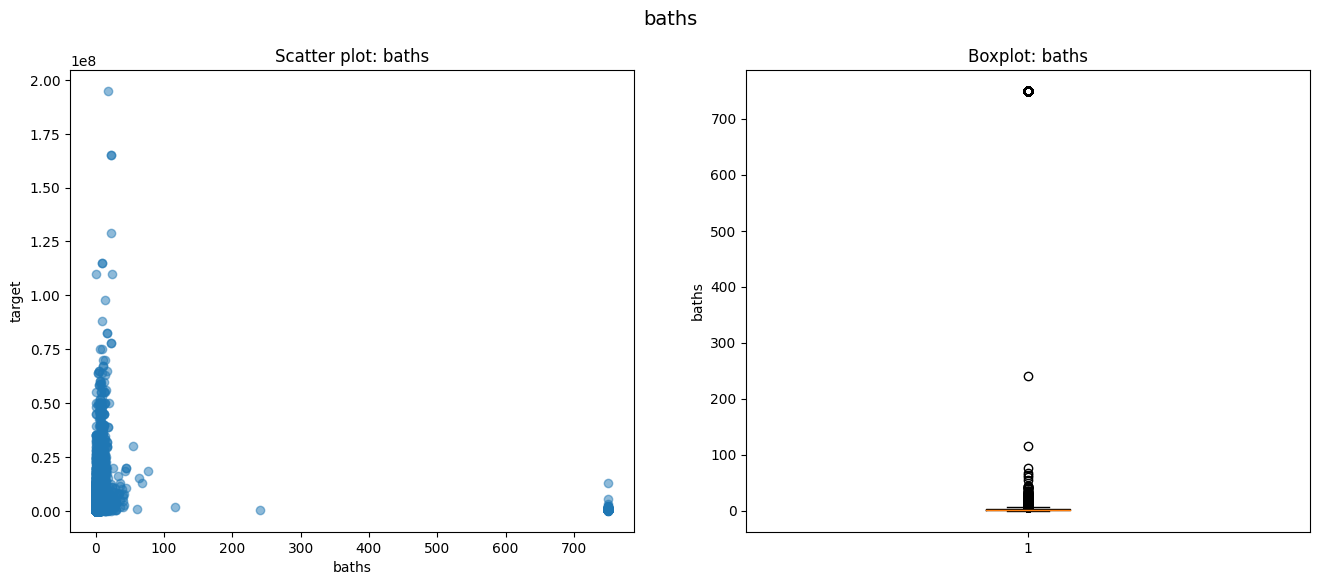

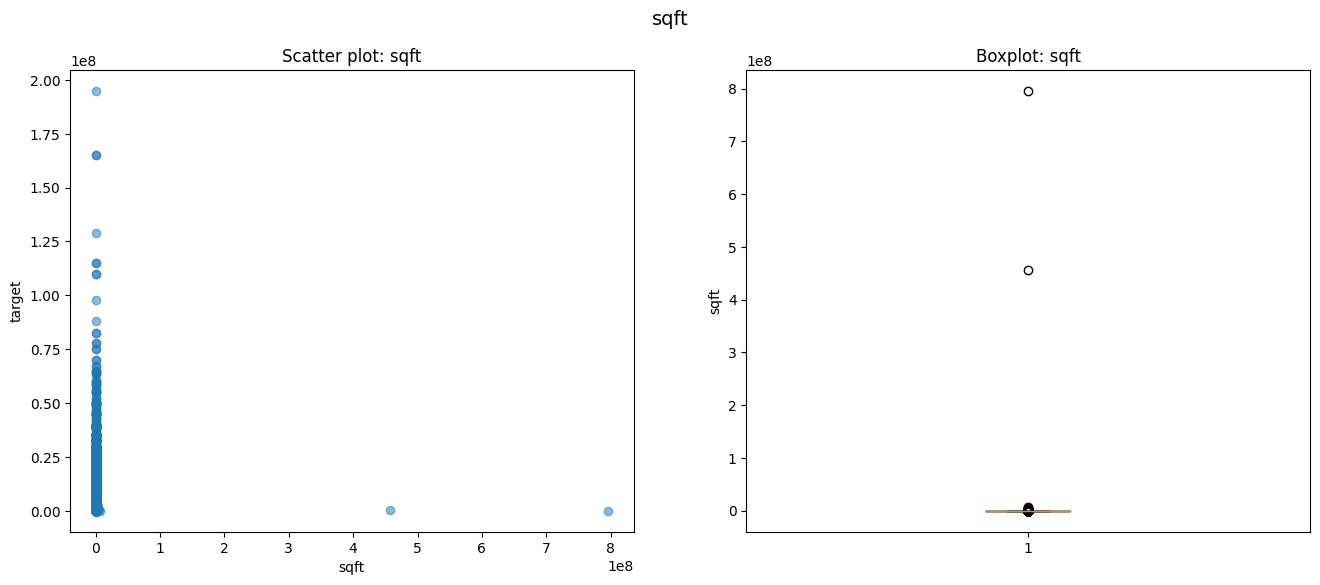

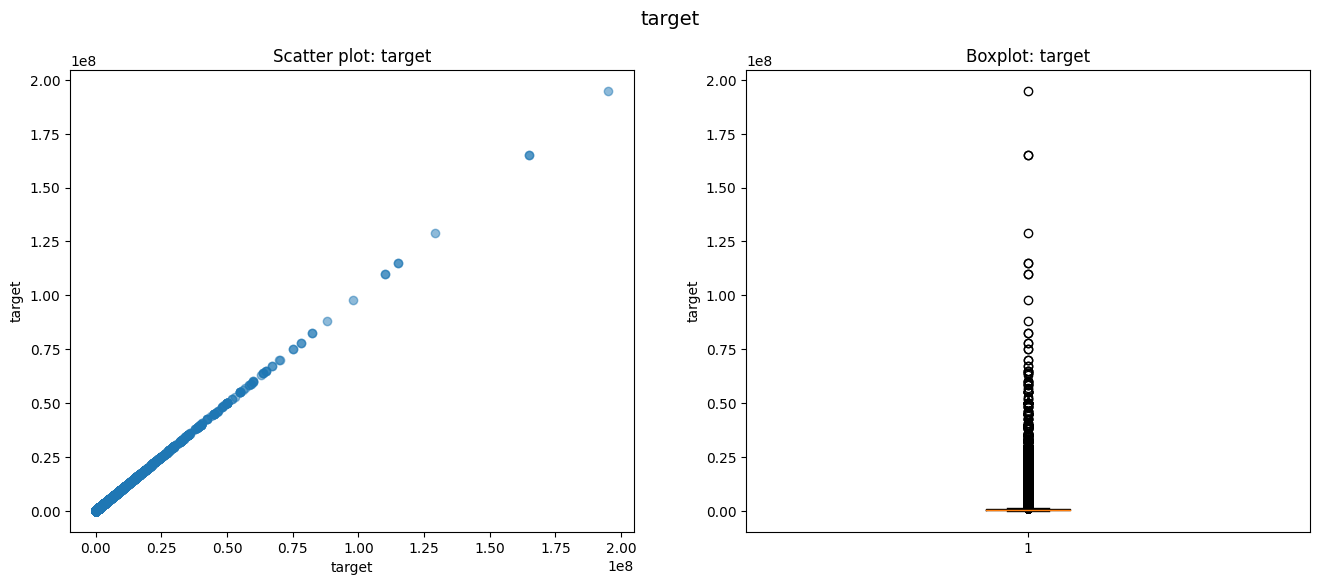

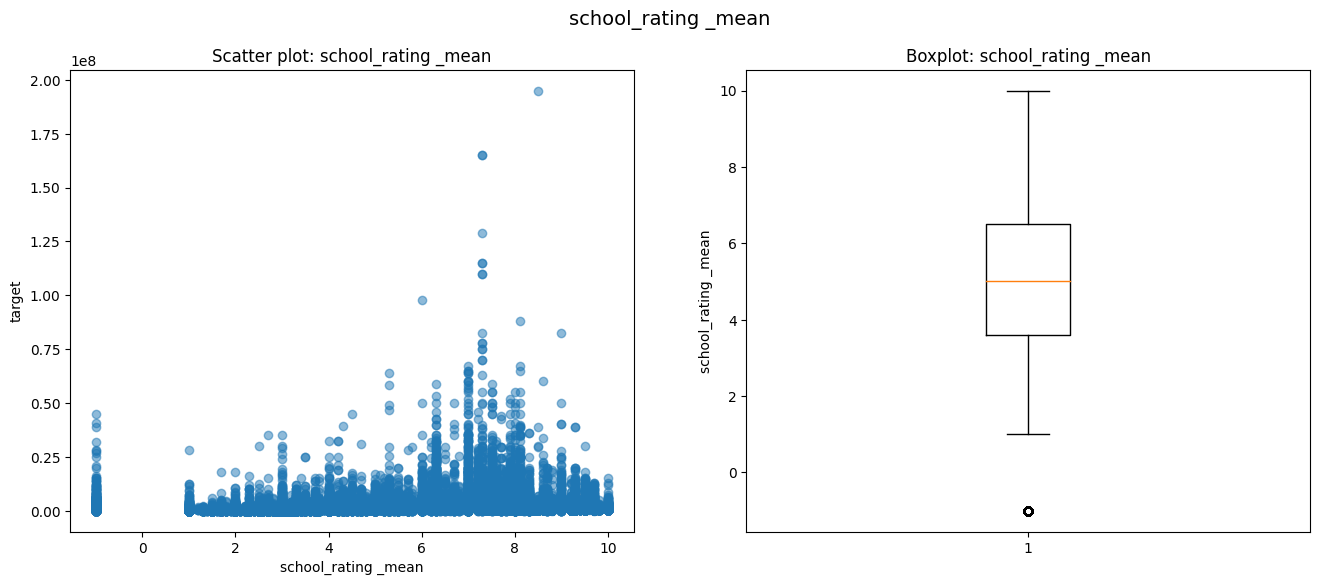

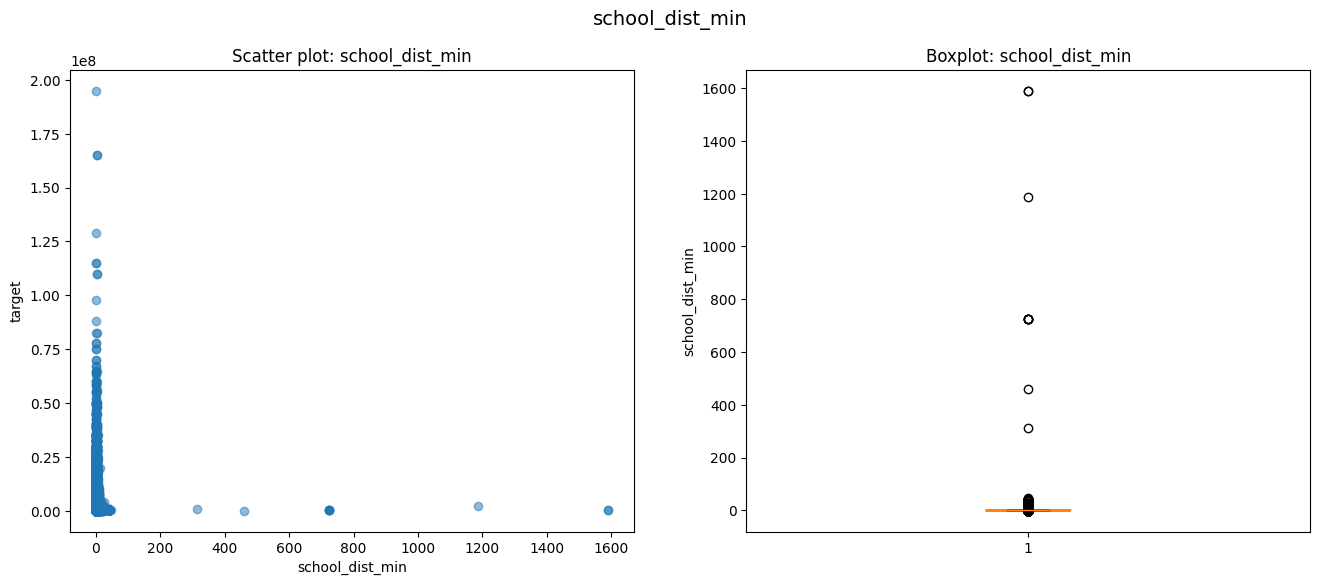

In [ ]:
# Создание графика рассеивания и ящика для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

По ванным комнатам нужно посмотреть 116, 241 и 750 
ванных комнат, - низкая цена при таком количестве,
По площади нужно посмотреть значения 0 и цена 195 милионов, а также площади больше 456
По школам расстояния больше 200

In [ ]:
condition1 = ((data['sqft'] == 0) & (data['target'] == 195000000)) | (data['sqft'] > 455000000)
filtered1_data = data[condition1]
# Вывести отфильтрованные строки
display(filtered1_data)

,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
55327,For Sale,1723 Pulte St,2.0,Cincinnati,795979430,OH,27500,0,single_family_home,1901,1,1,1,1,2.5,0.78
116538,For Sale,875 Nimes Rd,18.0,Los Angeles,0,CA,195000000,1,single_family_home,1935,1,1,1,1,8.5,1.30
331277,Active,5382 S Dixie Hwy,0.0,Glendale,456602479,KY,198000,0,multi_family_home,2012,1,1,0,False,6.3,3.10


In [ ]:

# Удаляем Выбросы, соответствующие условию
data.drop(data[condition1].index, inplace=True)

In [ ]:
condition2 = (data['school_dist_min']> 200)
filtered2_data = data[condition2]
# Вывести отфильтрованные строки
print(len(filtered2_data))
display(filtered2_data.head(5))

10


,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
23354,Other,73 Park Rd,4.0,Falcon Heights,6000,TX,670000,0,single_family_home,1980,1,1,1,False,6.3,312.40
96927,For Sale,108 N Nbelvedere Blvd #29,0.0,Santa Ana,890,TN,48640,0,single_family_home,1963,1,1,0,1,2.7,1590.36
149216,For Sale,253 W Wnorwood Ave,0.0,Spring,720,TN,18000,0,single_family_home,1950,1,0,0,1,7.5,460.86
179635,For Sale,5600 Pine Tree Dr,6.0,Miami Beach,4173,FL,2350000,1,single_family_home,1949,1,0,1,False,5.5,1187.14
190201,For Sale,2318 E Ewarren St,3.0,Needmore,1230,TN,57225,0,single_family_home,1953,1,1,0,1,5.5,725.17


In [ ]:
# Удаляем Выбросы, соответствующие условию
data.drop(data[condition2].index, inplace=True)

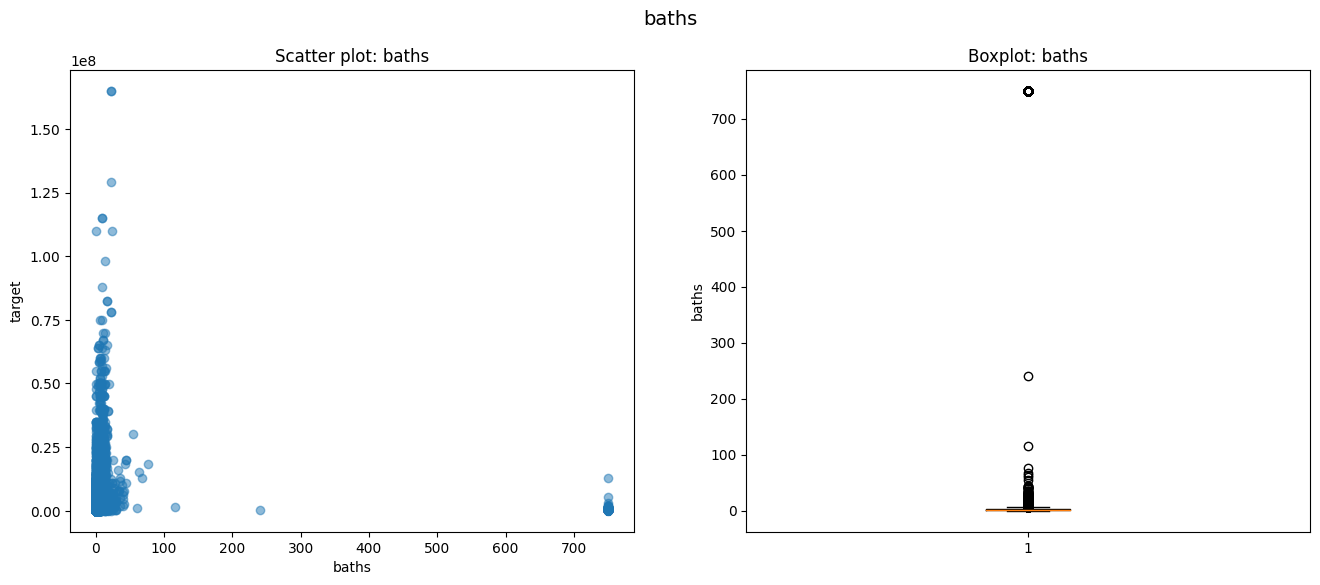

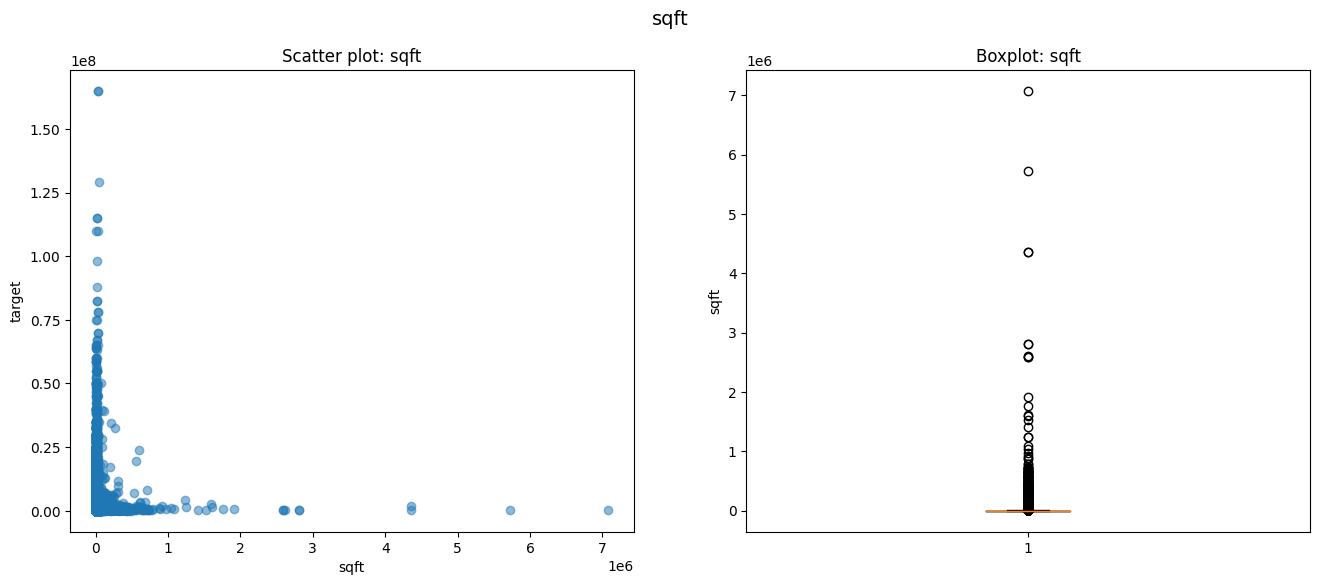

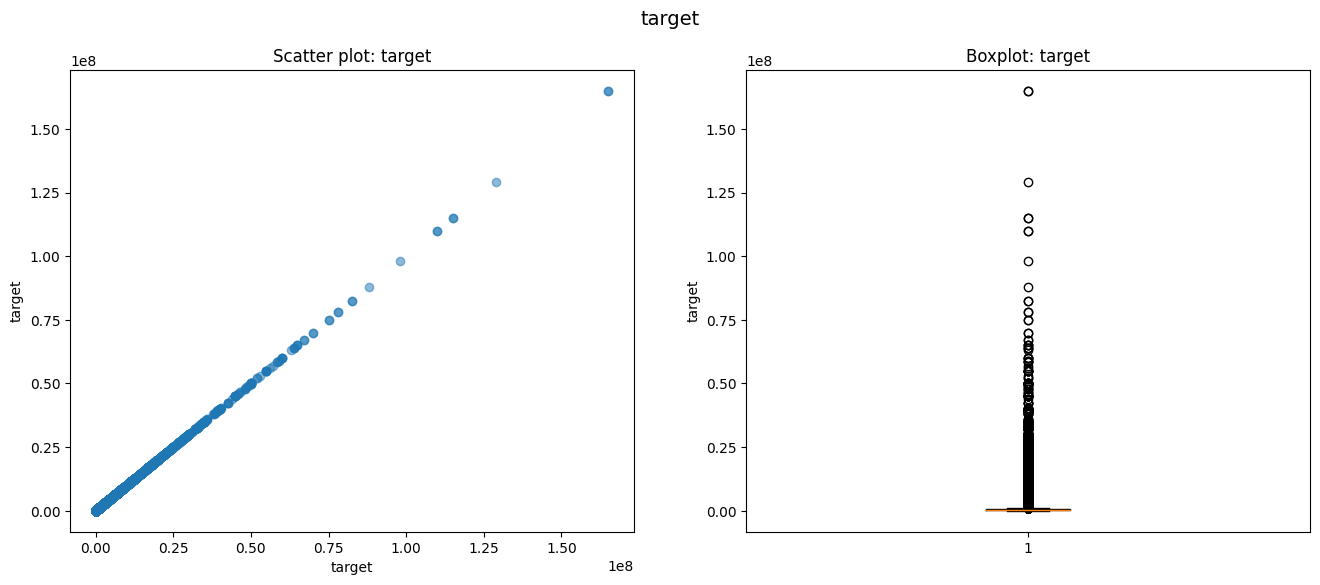

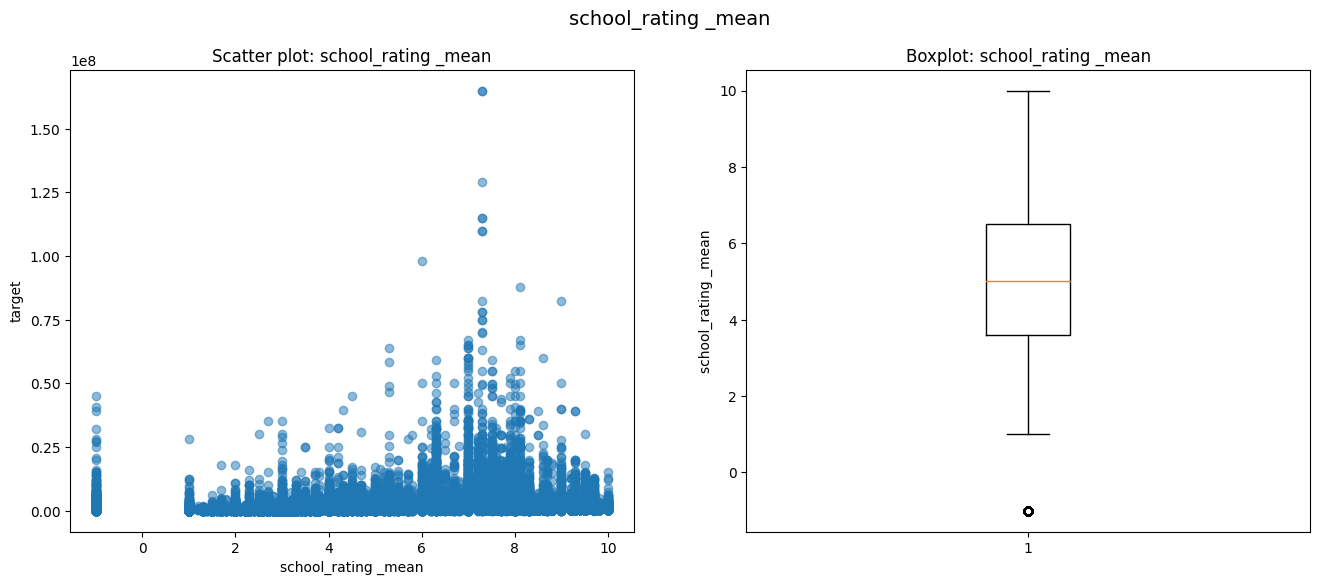

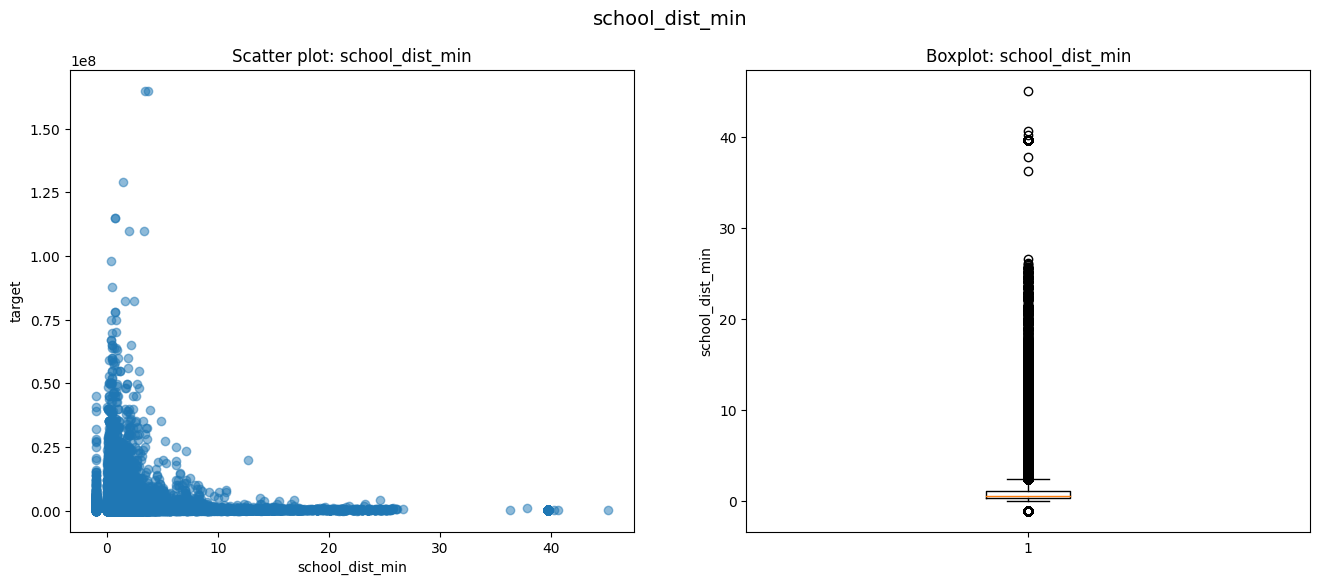

In [ ]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

In [ ]:
# Удаляем выбросы, соответствующие условию
data.drop(data[condition2].index, inplace=True)

C:\Users\Илья\AppData\Local\Temp\ipykernel_14960\2151465390.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.drop(data[condition2].index, inplace=True)


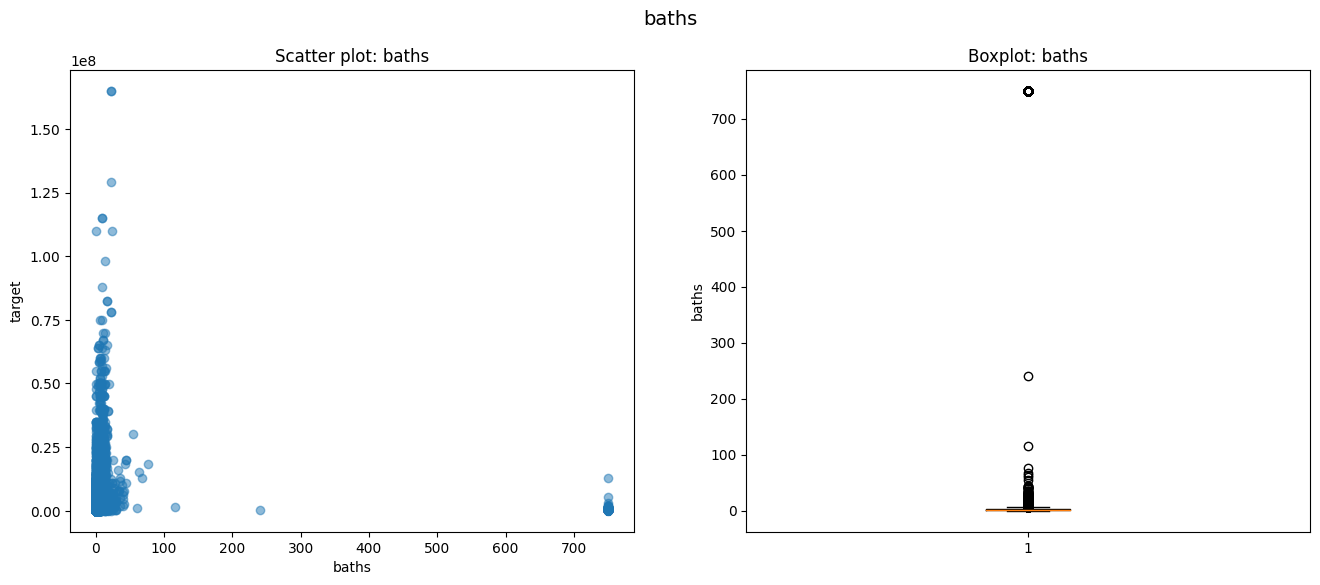

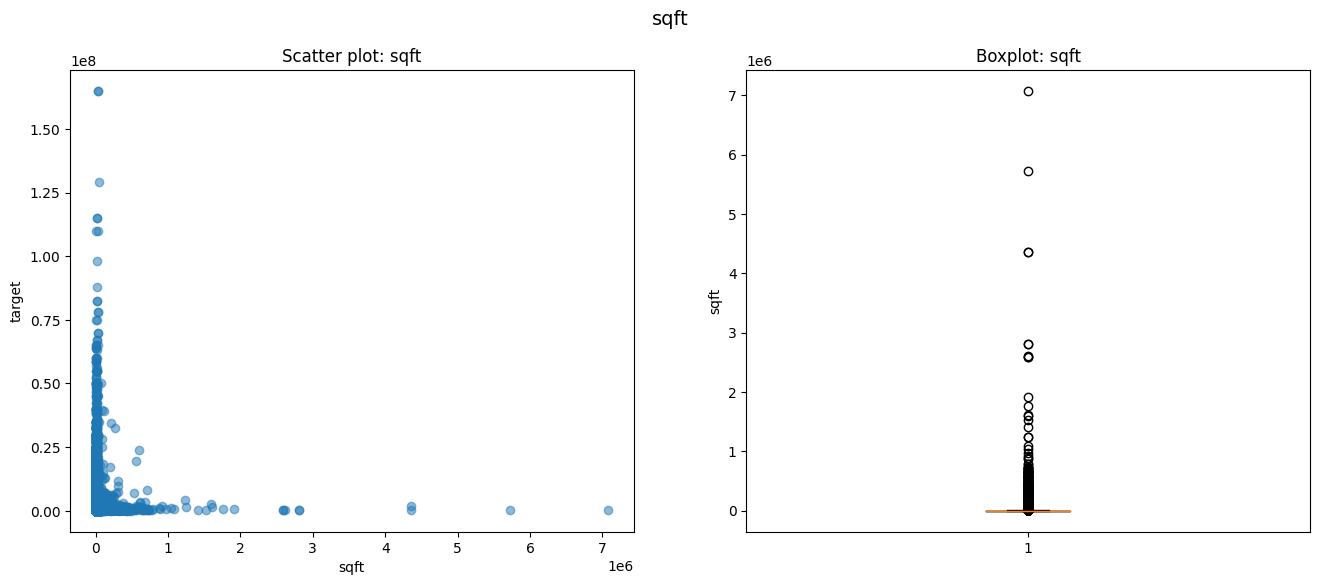

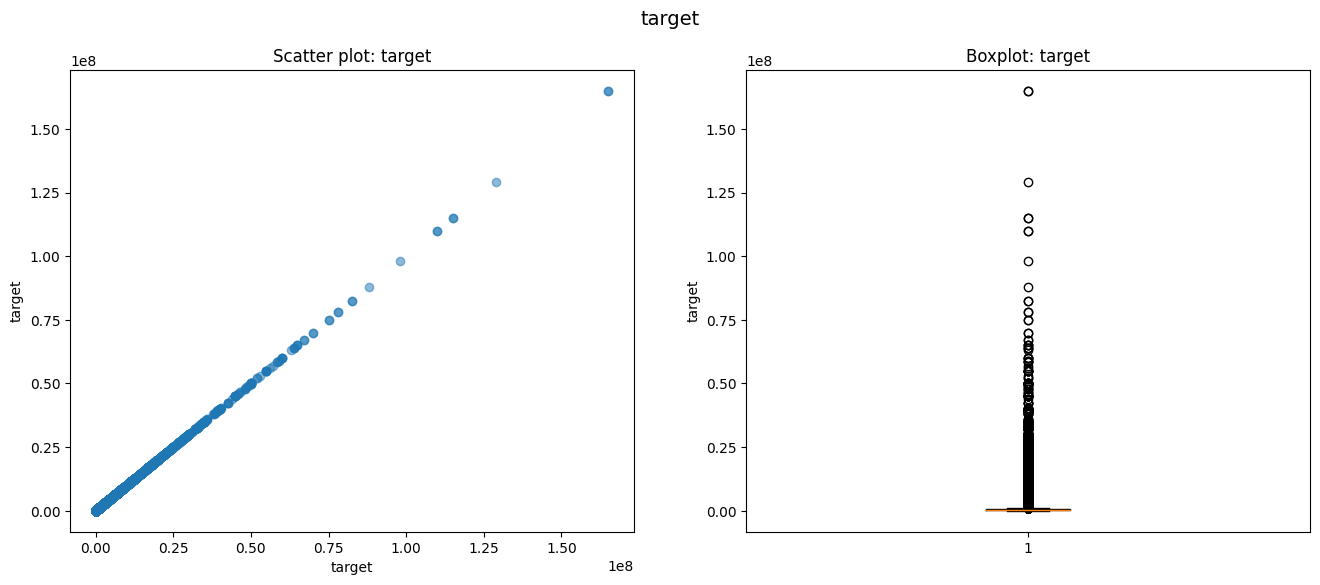

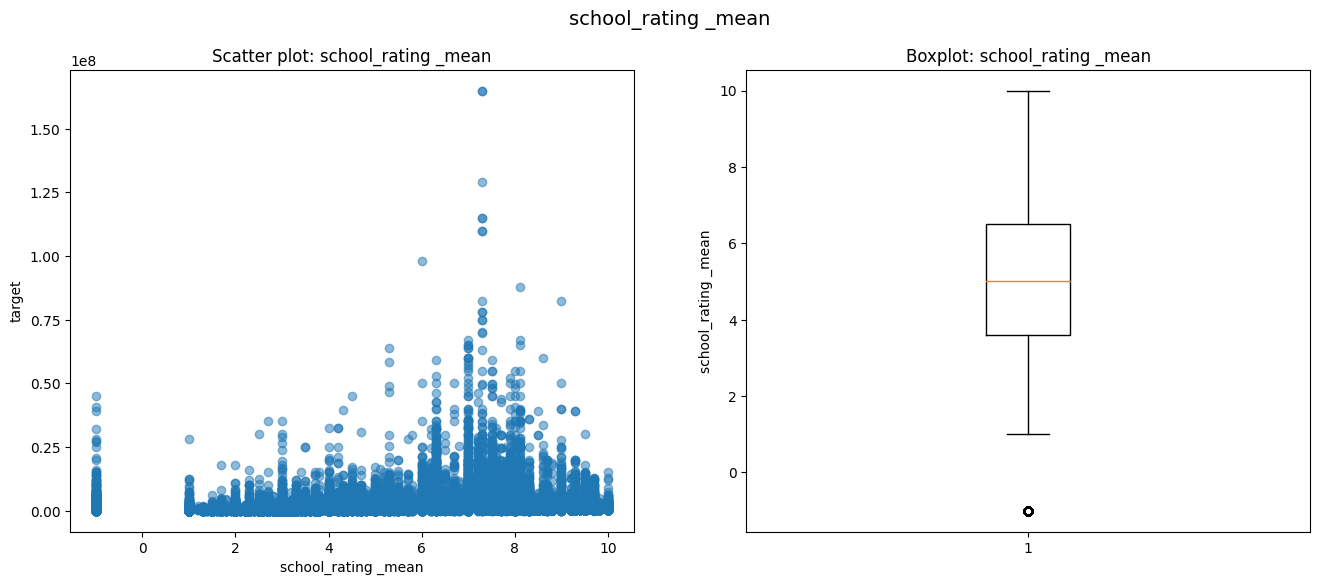

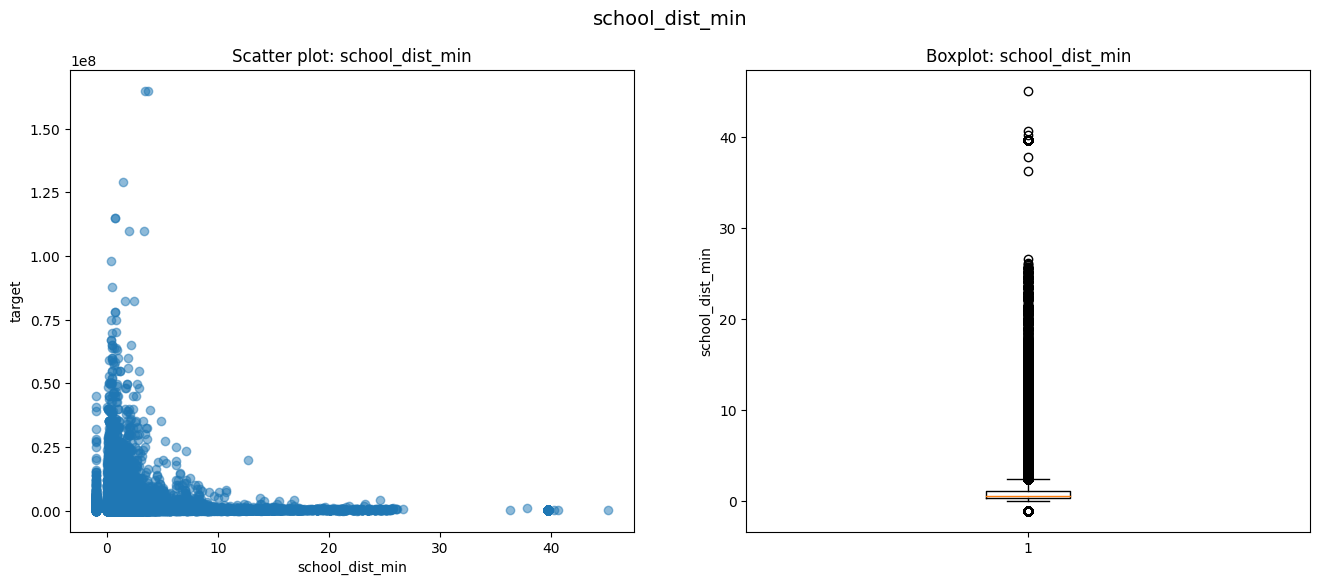

In [ ]:
# Создание графика рассеивания и ящика для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

In [ ]:
# Непонятные значения остались, выведем и посчитаем сколько у нас таких значений

condition3 = ((data['baths'] > 30) | (data['target'] > 750000)) | (data['sqft'] > 200000) |(data['school_dist_min']> 35)
filtered3_data = data[condition3]
# Вывести отфильтрованные строки
print(len(filtered3_data))
display(filtered3_data.head(3))

59438


,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,CA,2895000,1,single_family_home,1961,1,1,1,1,6.7,1.19
3,For Sale,4311 Livingston Ave,8.0,Dallas,6457,TX,2395000,0,single_family_home,2006,1,1,1,1,9.2,0.10
14,For Sale,930 52nd St,0.0,Brooklyn,0,NY,1650000,0,single_family_home,1905,0,1,0,False,6.3,0.20


In [ ]:
# Удаляем выбросы, соответствующие условию
data.drop(data[condition3].index, inplace=True)

In [ ]:
condition4 = ((data['baths'] < 1) | (data['sqft'] < 1))
filtered4_data = data[condition4]
# Вывести отфильтрованные строки
print(len(filtered4_data))
display(filtered4_data.head(3))

61726


,status,street,baths,city,sqft,state,target,pool,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
4,For Sale,1624 S Newkirk St,0.0,Philadelphia,897,PA,209000,0,townhouse,1920,1,1,0,False,-1.0,-1.0
5,Active,552 Casanova Ct,0.0,Poinciana,1507,FL,181500,0,other,2006,1,1,0,False,2.3,0.8
6,Active,6094 Mingle Dr,0.0,Memphis,0,TN,68000,0,other,1976,0,0,0,False,2.7,0.4


In [ ]:
# Удаляем выбросы, соответствующие условию
data.drop(data[condition4].index, inplace=True)

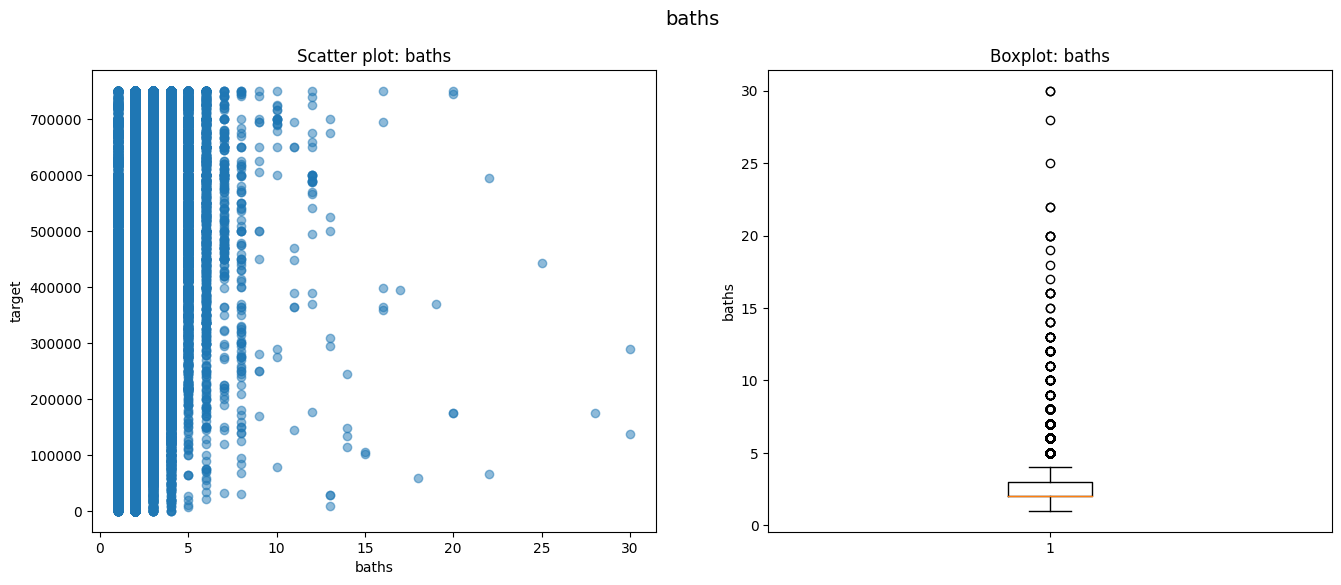

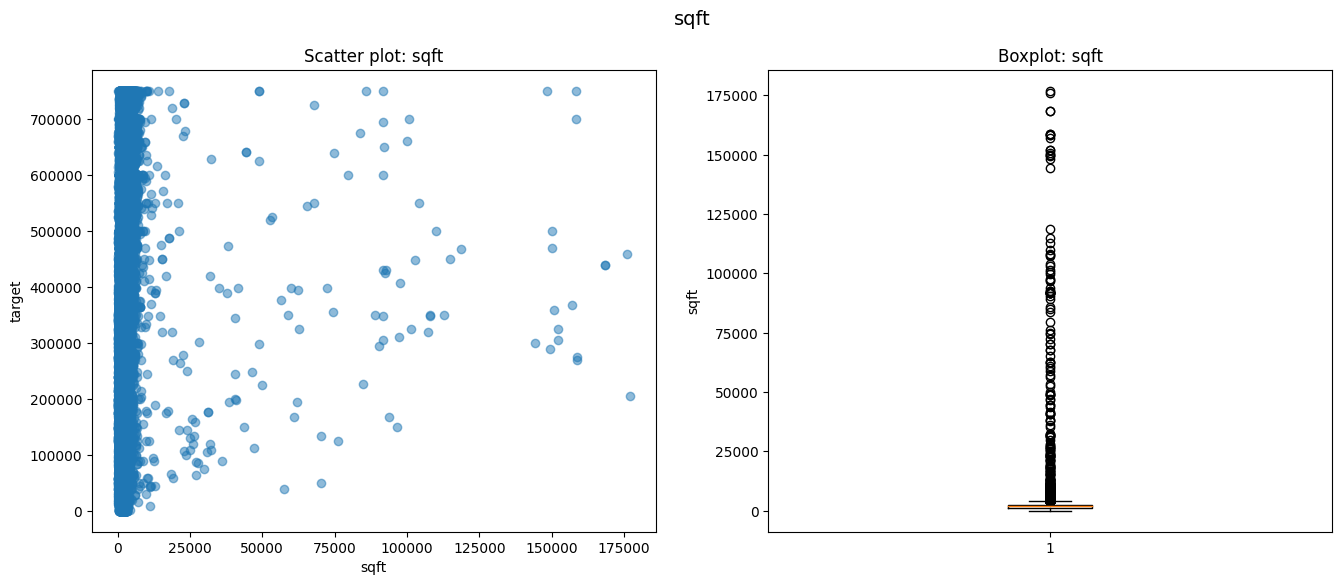

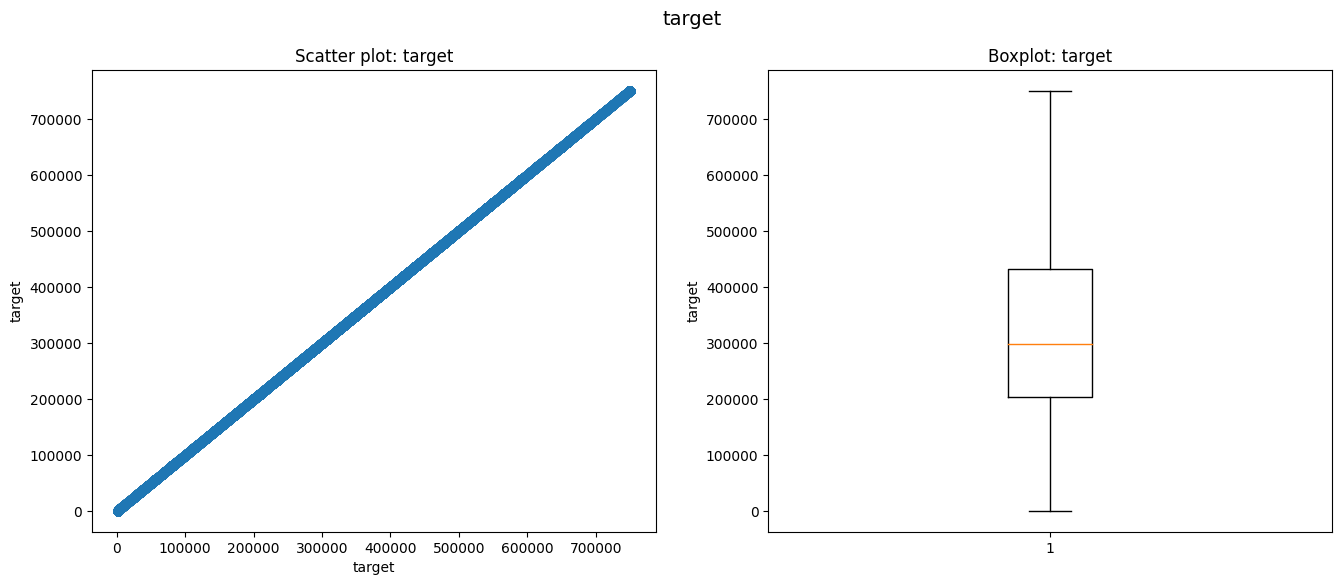

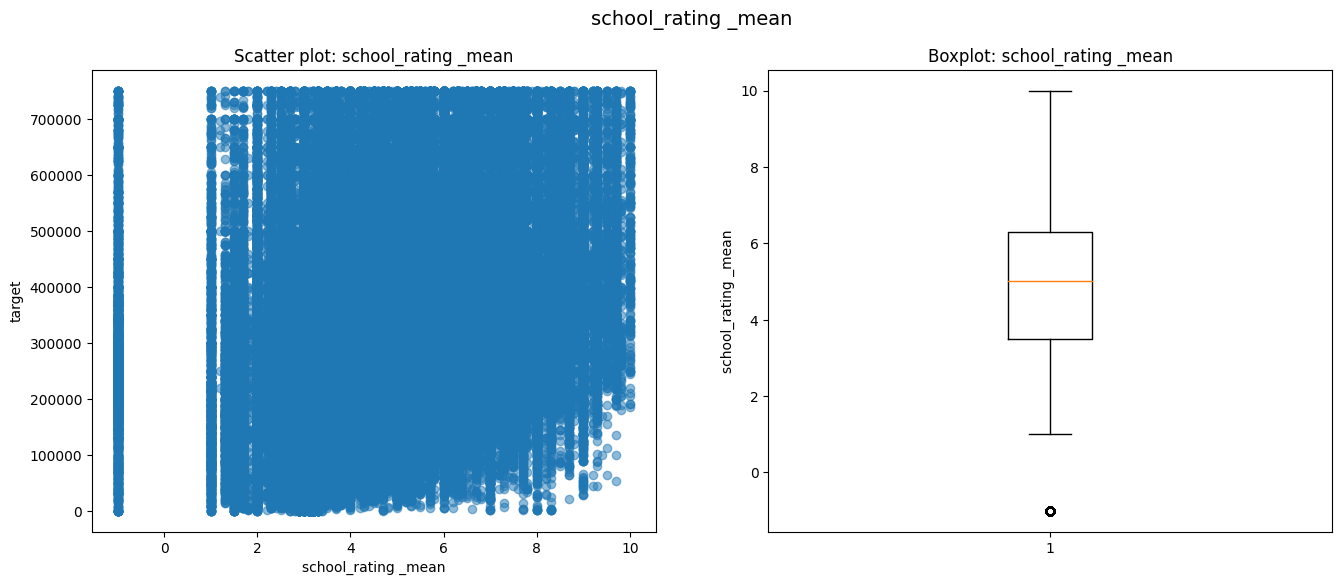

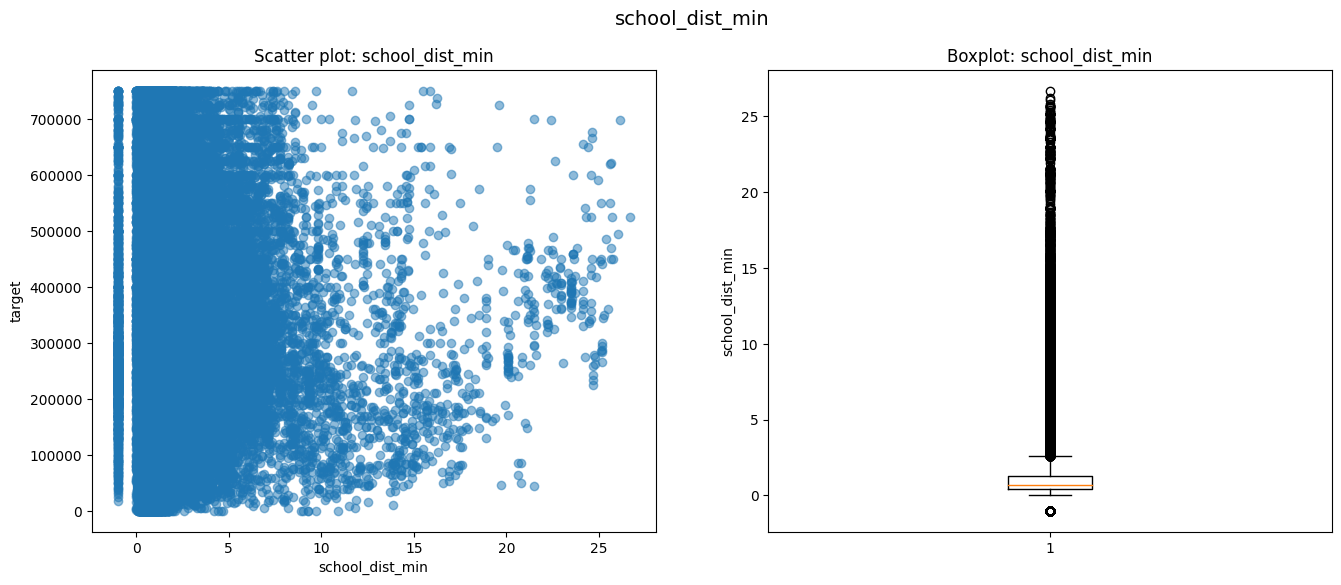

In [ ]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

In [ ]:
# удалим признак street
data = data.drop(columns=['street'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210668 entries, 0 to 331844
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               210668 non-null  object 
 1   baths                210668 non-null  float64
 2   city                 210668 non-null  object 
 3   sqft                 210668 non-null  int64  
 4   state                210668 non-null  object 
 5   target               210668 non-null  int64  
 6   pool                 210668 non-null  int64  
 7   Type                 210668 non-null  object 
 8   Year built           210668 non-null  object 
 9   Heating_encoded      210668 non-null  int64  
 10  Cooling_encoded      210668 non-null  int64  
 11  Parking_encoded      210668 non-null  int64  
 12  fireplace_encoded    210668 non-null  object 
 13  school_rating _mean  210668 non-null  float64
 14  school_dist_min      210668 non-null  float64
dtypes: float64(3), int64(6

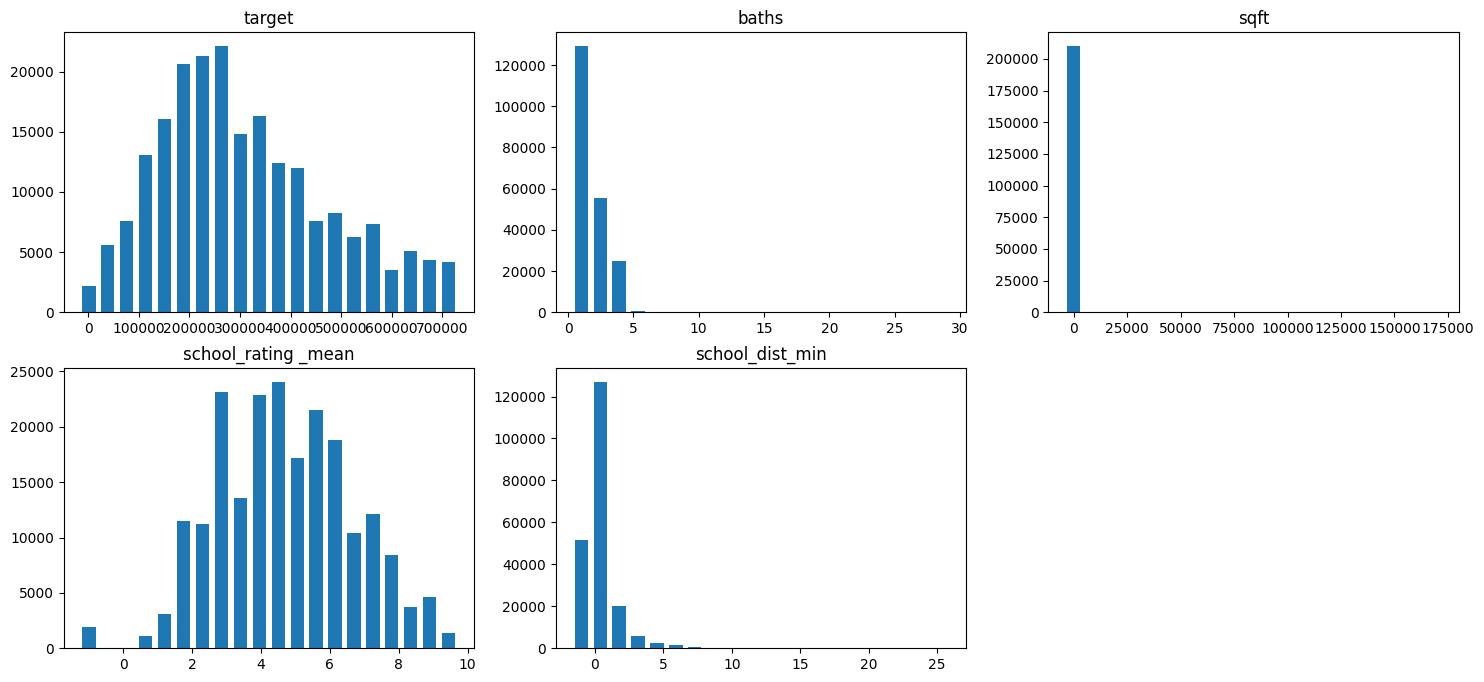

In [ ]:
visualize_distributions({
    'target': data['target'],
    'baths': data['baths'],
    'sqft': data['sqft'],
    'school_rating _mean': data['school_rating _mean'],
    'school_dist_min': data['school_dist_min'],
})

Числовые признаки необходимо нормализовать и логорифмировать для получения нормального распределения.

Ранг матрицы корреляций: 5
Определитель матрицы корреляций: 0.7119977


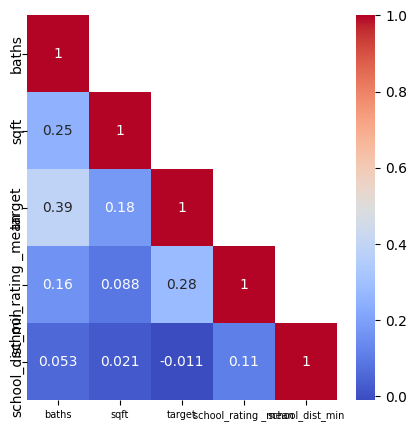

In [ ]:
# Проверяем на мультиколлинеарность и корреляцию числовых признаков между собой и с главным признаком "target":
# строим матрицу корреляций
corr_matrix = np.corrcoef(data[num_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))

# формируем нижний треугольник матрицы корреляций
corr_matrix_tril = np.tril(corr_matrix)
# заполняем верхний треугольник значениями NaN
corr_matrix_tril[corr_matrix_tril == 0] = np.nan

# создаем фигуру с автоматическим масштабированием
plt.figure(figsize=(len(data[num_features].columns), len(data[num_features].columns)))

# строим тепловую карту
sns.heatmap(corr_matrix_tril, annot=True, cmap='coolwarm', mask=np.isnan(corr_matrix_tril))
# добавляем подписи столбцов на тепловой карте
plt.xticks(np.arange(len(data[num_features].columns))+0.5, data[num_features].columns, rotation=0, ha='center', fontsize=7)
plt.yticks(np.arange(len(data[num_features].columns))+0.5, data[num_features].columns, ha='center', fontsize=10, va='center', rotation=90)
# отображаем график
plt.show()

Мультиколлинеарность отсутствует

Анализ номинативных переменных

Посмотрим на распределение стоимости квартир в зависимости от значения номинативных переменных.

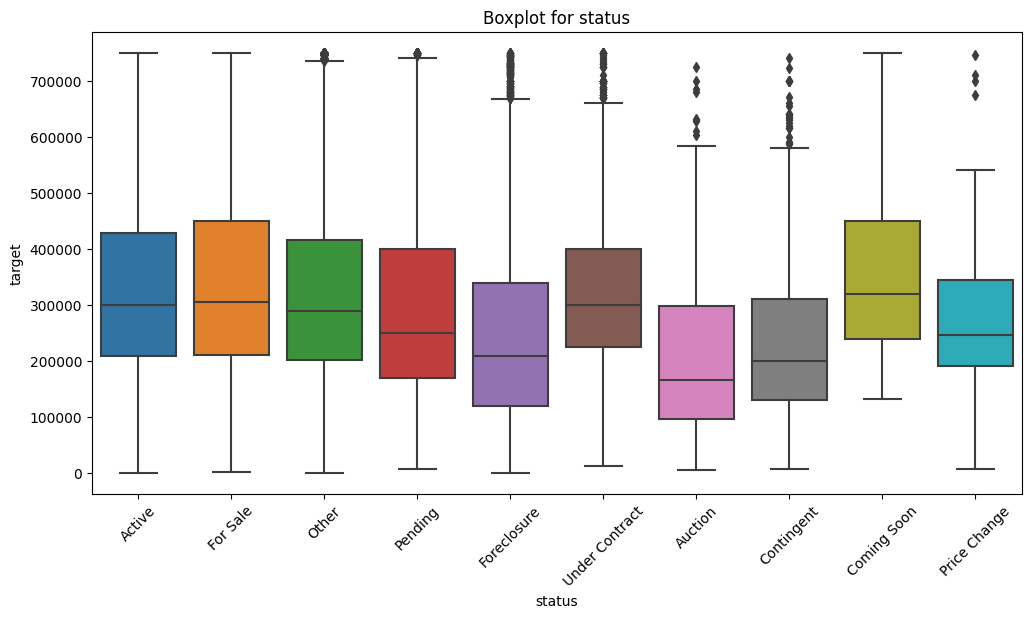

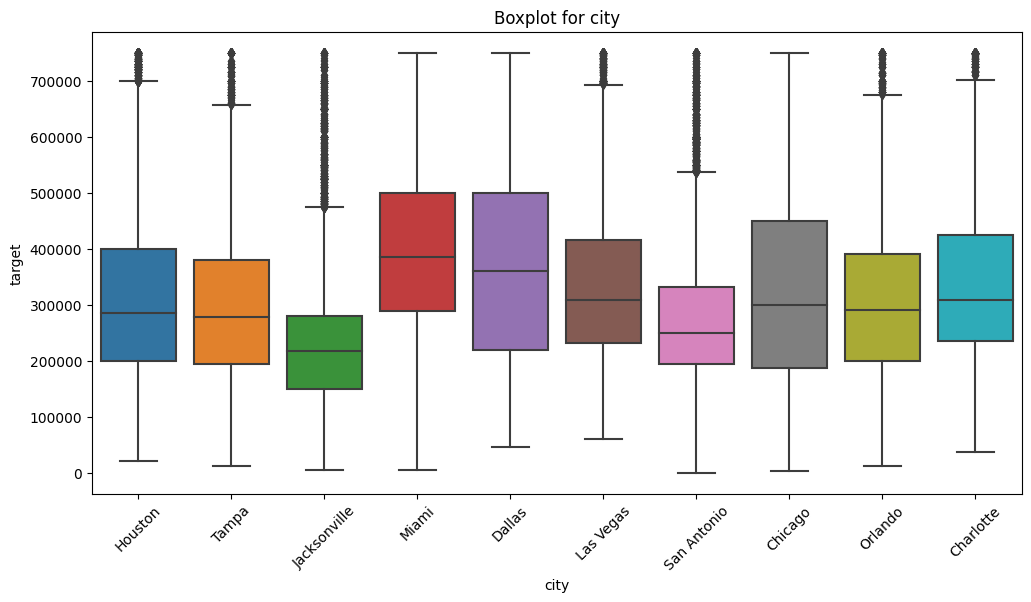

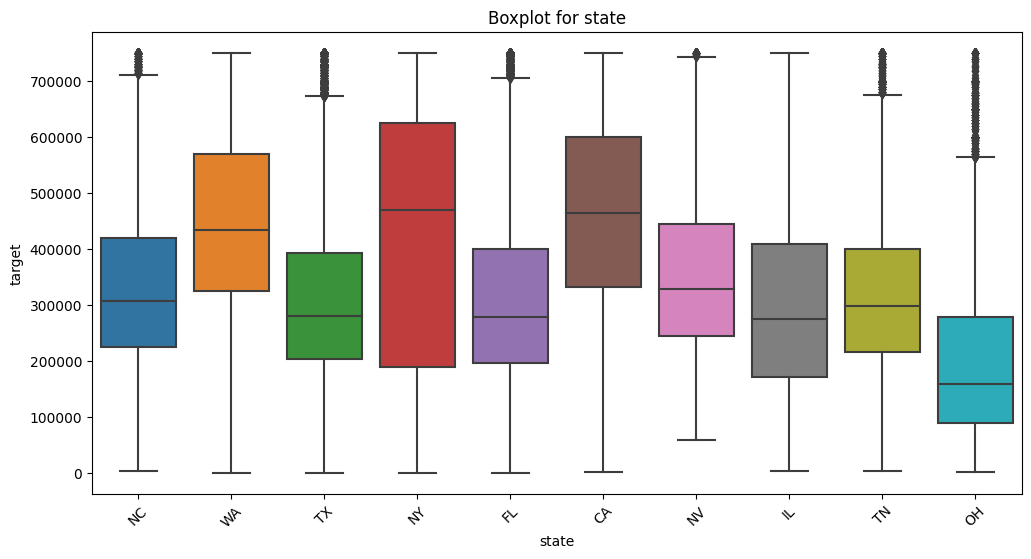

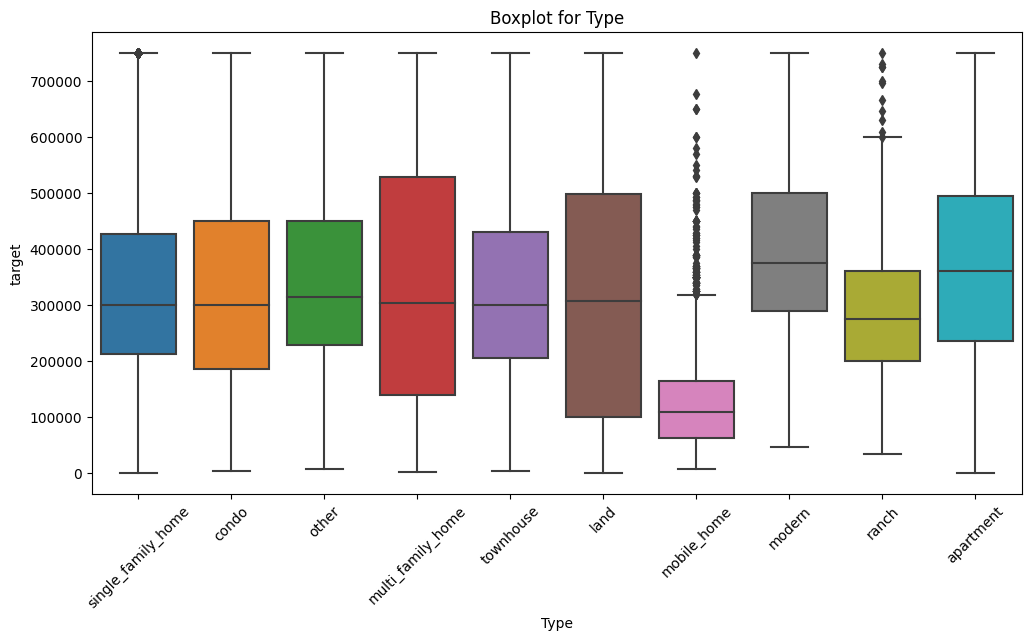

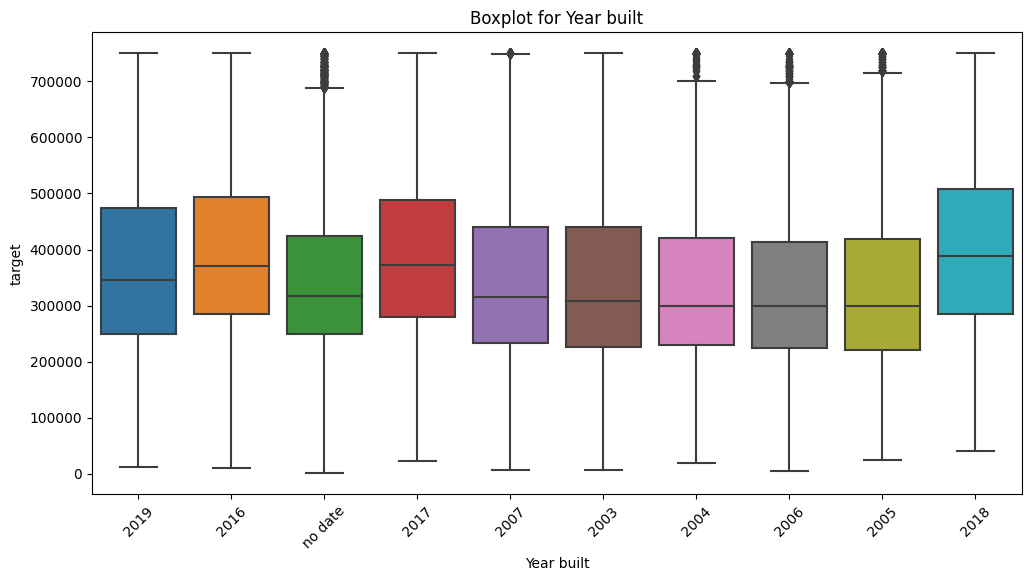

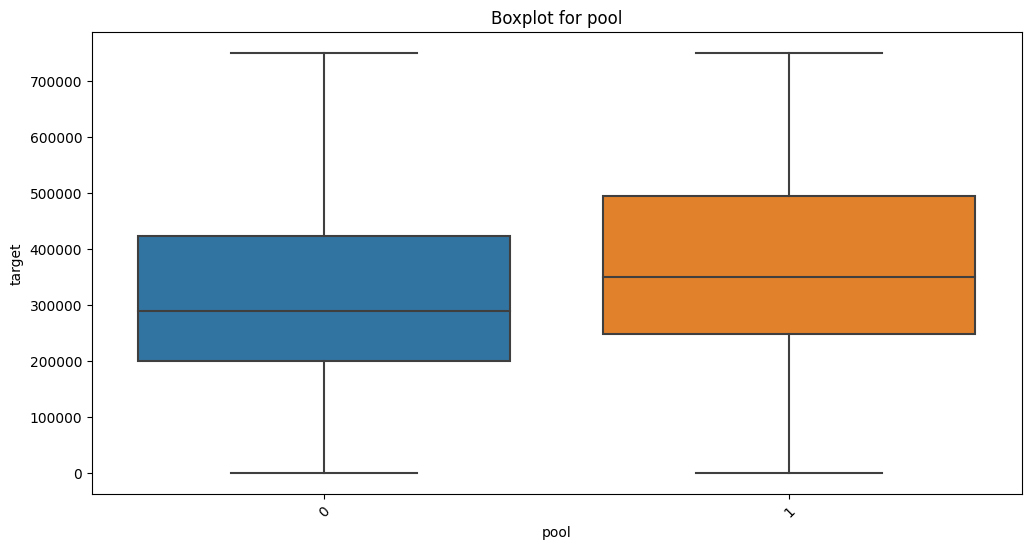

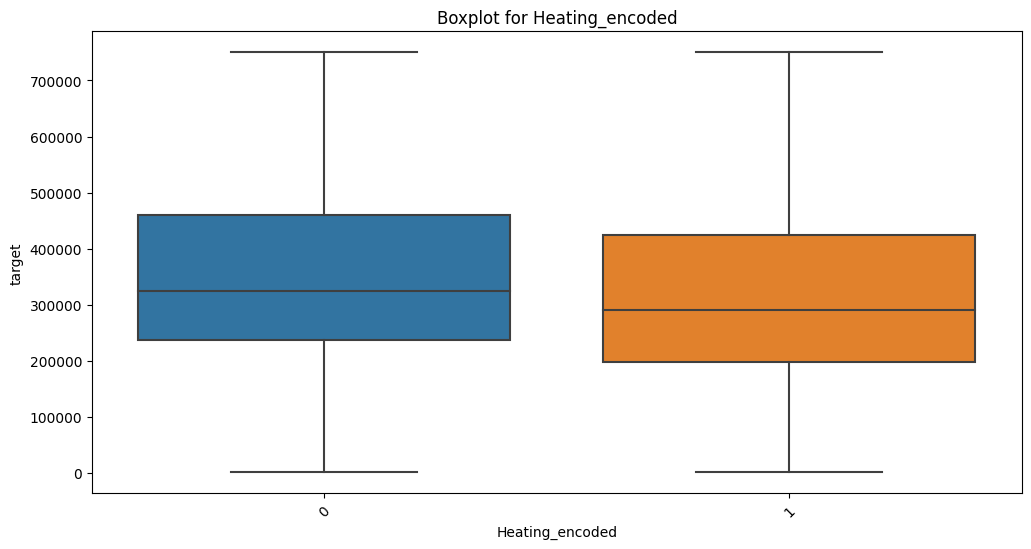

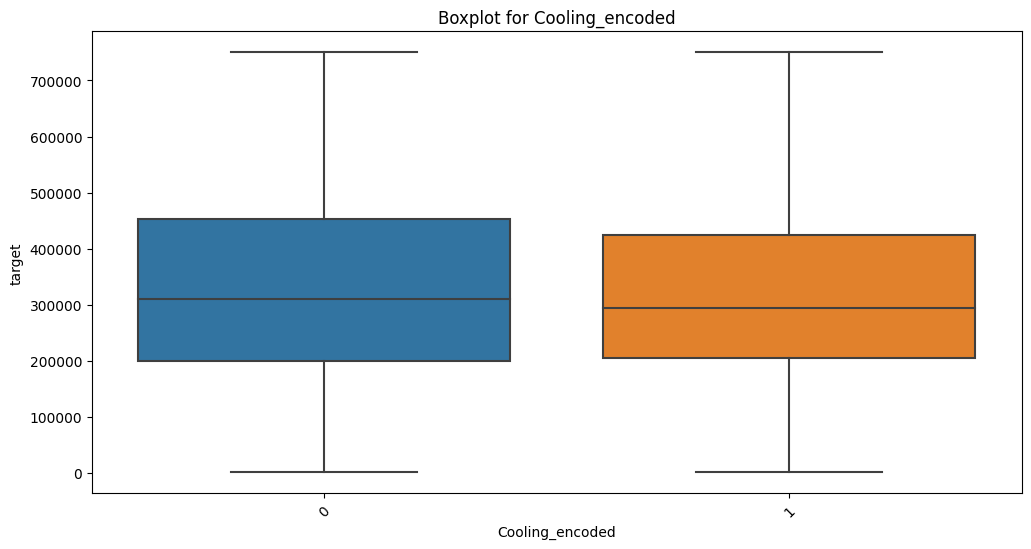

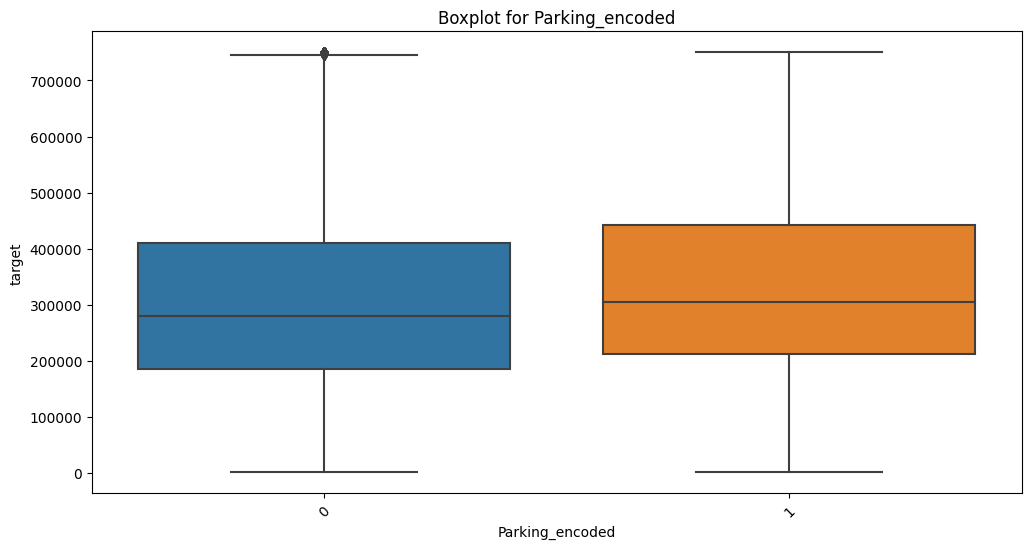

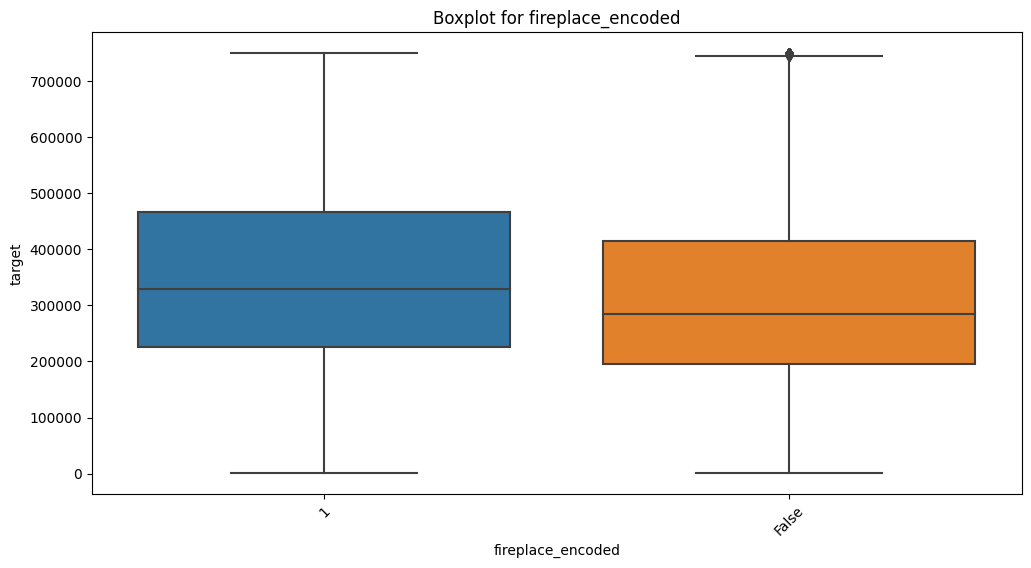

In [ ]:
for col in chain(cat_features, bin_features):
    get_boxplot(col)

По графикам наблюдаем, что все параметры, могут влиять на стоимость.

Результаты EDA
В результате EDA мы проделали следующую работу:

Избавились от пропусков, которые влияют на целевую переменную.
Избавились от выбросов.
Провели корреляционный анализ числовых признаков.
Посмотрели на распределение числовых признаков, в результате решили в дальнейшем нормализовать и логорифмировать числовые признаки.
Провели анализ номинативных переменных.
Сохраним датасет для дальнейшего использования при обучении модели.

df.to_csv('data_model_diplom.csv', index=False)

In [ ]:

data.to_csv('data_model.csv', index=False)